## Library Imports

In [1]:
from time import time
notebook_start_time = time()

In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## Constants and Utilities

In [3]:
SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH = "../input/petfinder-pawpularity-score"
FEATURES_PATH = "../input/petfinder-pretrained-features"

sc_y = StandardScaler()

In [4]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def head(x, no_of_ele=5) -> None:
    print(x[:no_of_ele])


def get_targets(path: str) -> np.ndarray:
    df = pd.read_csv(os.path.join(path, "train.csv"), engine="python")
    targets  = df.iloc[:, -1].copy().values
    return targets


def normalize(x):
    for i in range(x.shape[0]):
        x[i] = (x[i] - torch.min(x[i])) / (torch.max(x[i]) - torch.min(x[i]))
    return x


def show_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])    
    
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    plt.title("MSE Loss")
    plt.show()

## Dataset Template

In [5]:
class DS(Dataset):
    def __init__(self, features=None, targets=None):
        self.features = features
        self.targets  = targets
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor(self.targets[idx])

## Build DataLoaders

In [6]:
def build_dataloaders(tr_features: np.ndarray, va_features: np.ndarray,
                      tr_targets: np.ndarray, va_targets: np.ndarray,
                      batch_size: int, seed: int):

    breaker()
    print("Building Train and Validation DataLoaders ...")
    
    tr_data_setup = DS(features=tr_features, targets=tr_targets)
    va_data_setup = DS(features=va_features, targets=va_targets)
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
    }
    
    return dataloaders

## Build Model

In [7]:
def build_model(IL: int, HL: list, seed: int):
    class ANN(nn.Module):
        def __init__(self, IL=None, HL=None):
            super(ANN, self).__init__()

            self.predictor = nn.Sequential()
            if len(HL) == 0:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=1)))
            elif len(HL) == 1:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
                self.predictor.add_module("AN1", nn.ReLU())
                self.predictor.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.predictor.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=1)))
            elif len(HL) == 2:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
                self.predictor.add_module("AN1", nn.ReLU())
                self.predictor.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.predictor.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
                self.predictor.add_module("AN2", nn.ReLU())
                self.predictor.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
                self.predictor.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=1)))
            elif len(HL) == 3:
                self.predictor.add_module("BN1", nn.BatchNorm1d(num_features=IL, eps=1e-5))
                self.predictor.add_module("FC1", WN(nn.Linear(in_features=IL, out_features=HL[0])))
                self.predictor.add_module("AN1", nn.ReLU())
                self.predictor.add_module("BN2", nn.BatchNorm1d(num_features=HL[0], eps=1e-5))
                self.predictor.add_module("FC2", WN(nn.Linear(in_features=HL[0], out_features=HL[1])))
                self.predictor.add_module("AN2", nn.ReLU())
                self.predictor.add_module("BN3", nn.BatchNorm1d(num_features=HL[1], eps=1e-5))
                self.predictor.add_module("FC3", WN(nn.Linear(in_features=HL[1], out_features=HL[2])))
                self.predictor.add_module("AN3", nn.ReLU())
                self.predictor.add_module("BN4", nn.BatchNorm1d(num_features=HL[2], eps=1e-5))
                self.predictor.add_module("FC4", WN(nn.Linear(in_features=HL[2], out_features=1)))
        
        def get_optimizer(self, lr=1e-3, wd=0):
            params = [p for p in self.parameters() if p.requires_grad]
            return optim.Adam(params, lr=lr, weight_decay=wd)

        def get_plateau_scheduler(self, optimizer=None, patience=5, eps=1e-8):
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)

        def forward(self, x):
            return self.predictor(x)
    
    breaker()
    print("Building Model ...")
    print("\n{} -> {} -> 1".format(IL, HL))
    
    torch.manual_seed(seed)
    model = ANN(IL, HL=HL)
    
    return model

## Fit Helper

In [8]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None, early_stopping_patience=None,
        dataloaders=None, model_name=None, HL=None,
        fold=None, verbose=False):
    
    name = "./{}_Fold_{}_HL_{}_state.pt".format(model_name, fold, HL)
    
    breaker()
    print("Training ...")
    breaker()

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    model.to(DEVICE)
    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    breaker()
    print("Best Validation Loss at Epoch {}".format(BLE))
    breaker()
    print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    breaker()
    print("Training Completed")
    breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None):
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)
    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

## Search Optimal HL

In [9]:
def search():
    DEBUG = False
    
    ########### Params ###########
    
    batch_size = 64
    epochs, early_stopping = 25, 5
    lr, wd = 1e-3, 0
    patience, eps = 5, 1e-8
    
    if DEBUG:
        HLs = [[4]]
        n_splits = 3
    else:
        HLs = [[], [32], [64], [128], [256], [512]]
        n_splits = 5

    params = []
    model_names = ["mobilenet", "densenet", "resnet", "vgg"]

    ##############################
    
    targets = get_targets(PATH)
    
    search_optimal_start_time = time()
    for model_name in model_names:
        print("---")
        print("---")
        print("---")


        print("Loading Data ...")
        fold = 1
        features = np.load(os.path.join(FEATURES_PATH, "{}_features.npy".format(model_name)))
        
        breaker()
        print("Splitting into Train and Validation Sets ...")
        for tr_idx, va_idx in KFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(features):

            tr_features, va_features = features[tr_idx], features[va_idx]
            tr_targets, va_targets   = targets[tr_idx], targets[va_idx]

            tr_targets, va_targets   = tr_targets.reshape(-1, 1), va_targets.reshape(-1, 1)

            tr_targets = sc_y.fit_transform(tr_targets)
            va_targets = sc_y.transform(va_targets)

            dataloaders = build_dataloaders(tr_features, va_features, 
                                             tr_targets, va_targets, 
                                             batch_size, SEED)

            for HL in HLs:
                breaker()
                print("{} Features, Fold: {}, HL: {}".format(model_name, fold, HL))
                model = build_model(IL=tr_features.shape[1], HL=HL, seed=SEED)
                optimizer = model.get_optimizer(lr=lr, wd=wd)
                scheduler = None
                # scheduler = model.get_plateau_scheduler(optimizer, patience, eps)

                L, _, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                                 epochs=epochs, early_stopping_patience=early_stopping,
                                 dataloaders=dataloaders, model_name=model_name, HL=HL,
                                 fold=fold, verbose=True)

                y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
                RMSE = np.sqrt(mean_squared_error(y_pred, va_targets))
                print("Validation RMSE : {:.5f}".format(RMSE))
                breaker()
                show_graphs(L)

                params_dict = {"Model" : model_name, "Fold" : fold, "HL" : HL, "RMSE" : RMSE}
                params.append(params_dict)
            
            fold += 1
    
    breaker()
    print("Total Time to search for optimal HL : {:.2f} minutes".format((time() - search_optimal_start_time)/60))
    breaker()
    
    return params

---
---
---
Loading Data ...

**************************************************

Splitting into Train and Validation Sets ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

mobilenet Features, Fold: 1, HL: []

**************************************************

Building Model ...

1280 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97396 | Valid Loss: 0.93336 | Time: 0.72 seconds
Epoch: 2 | Train Loss: 0.85253 | Valid Loss: 0.90047 | Time: 0.50 seconds
Epoch: 3 | Train Loss: 0.82877 | Valid Loss: 0.89961 | Time: 0.44 seconds
Epoch: 4 | Train Loss: 0.81178 | Valid Loss: 0.88058 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.79463 | Valid Loss: 0.88940 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.79026 | Valid Loss: 0.88493 | Time: 0.43 seconds
Epoch: 7 | Train Loss: 0.78331 | 

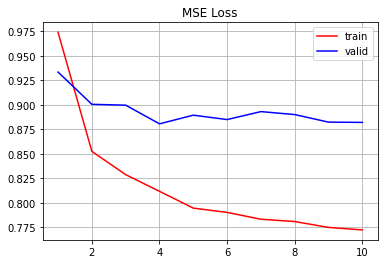


**************************************************

mobilenet Features, Fold: 1, HL: [32]

**************************************************

Building Model ...

1280 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.93550 | Valid Loss: 0.89203 | Time: 0.57 seconds
Epoch: 2 | Train Loss: 0.77144 | Valid Loss: 0.91139 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.71755 | Valid Loss: 0.92162 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.68810 | Valid Loss: 0.93096 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.64486 | Valid Loss: 0.96621 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.60184 | Valid Loss: 0.98389 | Time: 0.58 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************



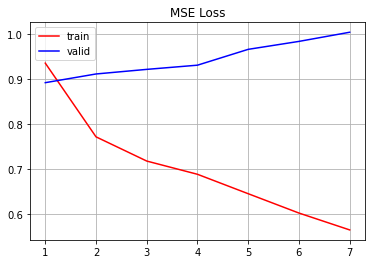


**************************************************

mobilenet Features, Fold: 1, HL: [64]

**************************************************

Building Model ...

1280 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96673 | Valid Loss: 0.89824 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.77054 | Valid Loss: 0.88476 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.71778 | Valid Loss: 0.92523 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.66816 | Valid Loss: 0.94542 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.61667 | Valid Loss: 0.94820 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.56691 | Valid Loss: 0.96299 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.51288 | Valid Loss: 1.02138 | Time: 0.75 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Ep

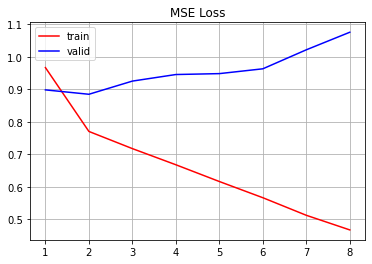


**************************************************

mobilenet Features, Fold: 1, HL: [128]

**************************************************

Building Model ...

1280 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.01255 | Valid Loss: 0.92233 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.75559 | Valid Loss: 0.92820 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.68907 | Valid Loss: 0.93413 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.62368 | Valid Loss: 0.96425 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.56886 | Valid Loss: 0.96686 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.51796 | Valid Loss: 1.02025 | Time: 0.57 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

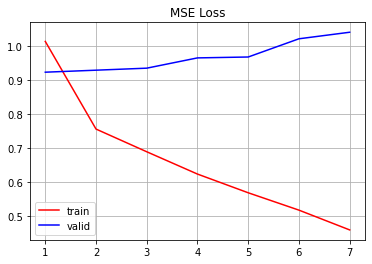


**************************************************

mobilenet Features, Fold: 1, HL: [256]

**************************************************

Building Model ...

1280 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06557 | Valid Loss: 0.93819 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.76183 | Valid Loss: 0.94911 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.67927 | Valid Loss: 0.94641 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.60894 | Valid Loss: 0.95359 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.54508 | Valid Loss: 0.99524 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.47750 | Valid Loss: 1.01293 | Time: 0.57 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

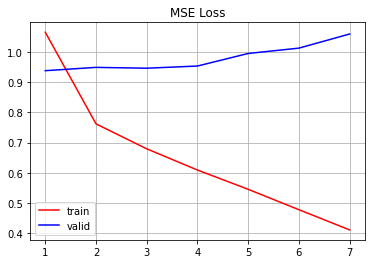


**************************************************

mobilenet Features, Fold: 1, HL: [512]

**************************************************

Building Model ...

1280 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.19193 | Valid Loss: 1.07248 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.76692 | Valid Loss: 0.96543 | Time: 0.74 seconds
Epoch: 3 | Train Loss: 0.68583 | Valid Loss: 0.97322 | Time: 0.62 seconds
Epoch: 4 | Train Loss: 0.60258 | Valid Loss: 0.97151 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.53337 | Valid Loss: 0.98942 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.46782 | Valid Loss: 1.05704 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.40542 | Valid Loss: 1.04407 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

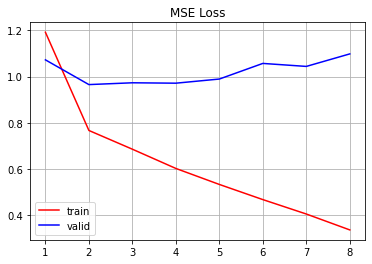


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

mobilenet Features, Fold: 2, HL: []

**************************************************

Building Model ...

1280 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97200 | Valid Loss: 0.82946 | Time: 0.43 seconds
Epoch: 2 | Train Loss: 0.84814 | Valid Loss: 0.82468 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.82060 | Valid Loss: 0.80137 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.80861 | Valid Loss: 0.80513 | Time: 0.45 seconds
Epoch: 5 | Train Loss: 0.79875 | Valid Loss: 0.78712 | Time: 0.44 seconds
Epoch: 6 | Train Loss: 0.78479 | Valid Loss: 0.79086 | Time: 0.43 seconds
Epoch: 7 | Train Loss: 0.78192 | Valid Loss: 0.79146 | Time: 0.43 seconds
Epoch: 8 | Train Loss: 0.77694 | Valid Loss: 0.79416 | Time: 0.44 seconds
Epoch: 9 | T

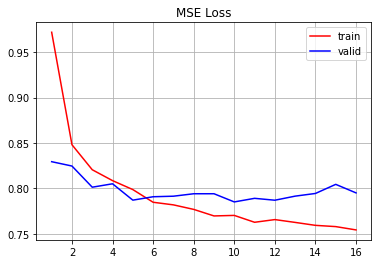


**************************************************

mobilenet Features, Fold: 2, HL: [32]

**************************************************

Building Model ...

1280 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.93493 | Valid Loss: 0.79142 | Time: 0.57 seconds
Epoch: 2 | Train Loss: 0.77176 | Valid Loss: 0.78647 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.72781 | Valid Loss: 0.82318 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.68353 | Valid Loss: 0.83970 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.65191 | Valid Loss: 0.84933 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.60424 | Valid Loss: 0.91372 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.55881 | Valid Loss: 0.88161 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Ep

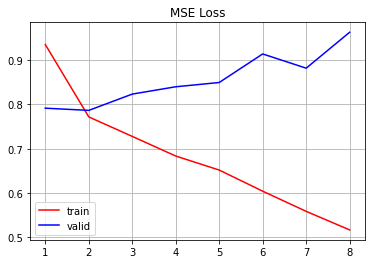


**************************************************

mobilenet Features, Fold: 2, HL: [64]

**************************************************

Building Model ...

1280 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94051 | Valid Loss: 0.78928 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.76421 | Valid Loss: 0.79859 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.71911 | Valid Loss: 0.81420 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.66694 | Valid Loss: 0.85095 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.62380 | Valid Loss: 0.86989 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.56935 | Valid Loss: 0.88617 | Time: 0.57 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************



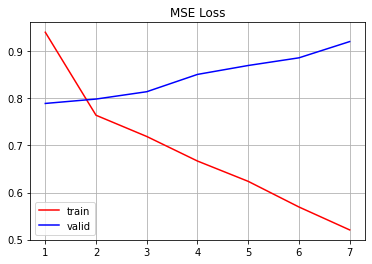


**************************************************

mobilenet Features, Fold: 2, HL: [128]

**************************************************

Building Model ...

1280 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.99636 | Valid Loss: 0.83058 | Time: 0.57 seconds
Epoch: 2 | Train Loss: 0.75911 | Valid Loss: 0.82707 | Time: 0.75 seconds
Epoch: 3 | Train Loss: 0.69755 | Valid Loss: 0.85049 | Time: 0.64 seconds
Epoch: 4 | Train Loss: 0.63827 | Valid Loss: 0.86781 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.57275 | Valid Loss: 0.87699 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.52653 | Valid Loss: 0.92942 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.46608 | Valid Loss: 0.93650 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

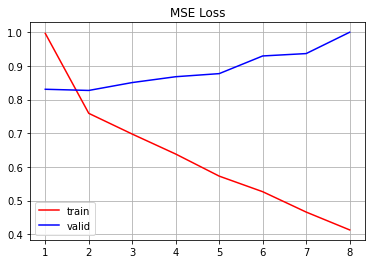


**************************************************

mobilenet Features, Fold: 2, HL: [256]

**************************************************

Building Model ...

1280 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06652 | Valid Loss: 0.84195 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.75728 | Valid Loss: 0.81895 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.68098 | Valid Loss: 0.83894 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.61565 | Valid Loss: 0.84382 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.55780 | Valid Loss: 0.88349 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.49088 | Valid Loss: 0.92649 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.43068 | Valid Loss: 0.95283 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

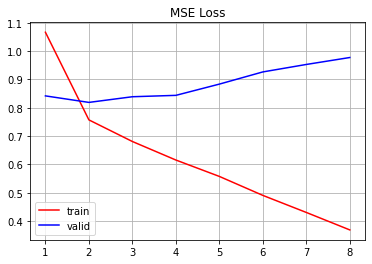


**************************************************

mobilenet Features, Fold: 2, HL: [512]

**************************************************

Building Model ...

1280 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.28293 | Valid Loss: 0.92056 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.77249 | Valid Loss: 0.89508 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.66454 | Valid Loss: 0.90438 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.58343 | Valid Loss: 0.90053 | Time: 0.77 seconds
Epoch: 5 | Train Loss: 0.52051 | Valid Loss: 0.91708 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.44934 | Valid Loss: 0.96329 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.39224 | Valid Loss: 0.97338 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

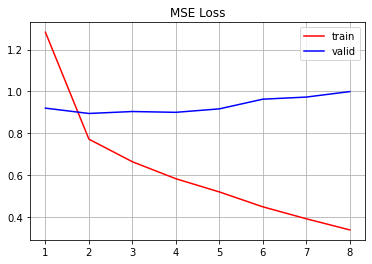


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

mobilenet Features, Fold: 3, HL: []

**************************************************

Building Model ...

1280 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98512 | Valid Loss: 0.93118 | Time: 0.43 seconds
Epoch: 2 | Train Loss: 0.86055 | Valid Loss: 0.90036 | Time: 0.43 seconds
Epoch: 3 | Train Loss: 0.82279 | Valid Loss: 0.89675 | Time: 0.43 seconds
Epoch: 4 | Train Loss: 0.80705 | Valid Loss: 0.90138 | Time: 0.43 seconds
Epoch: 5 | Train Loss: 0.79733 | Valid Loss: 0.90746 | Time: 0.43 seconds
Epoch: 6 | Train Loss: 0.78812 | Valid Loss: 0.90448 | Time: 0.44 seconds
Epoch: 7 | Train Loss: 0.78213 | Valid Loss: 0.88541 | Time: 0.43 seconds
Epoch: 8 | Train Loss: 0.77234 | Valid Loss: 0.88656 | Time: 0.43 seconds
Epoch: 9 | T

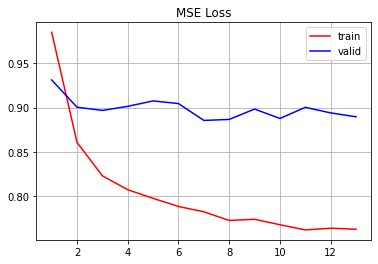


**************************************************

mobilenet Features, Fold: 3, HL: [32]

**************************************************

Building Model ...

1280 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.93740 | Valid Loss: 0.89582 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.78203 | Valid Loss: 0.89226 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.73153 | Valid Loss: 0.89478 | Time: 0.87 seconds
Epoch: 4 | Train Loss: 0.68665 | Valid Loss: 0.89837 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.65584 | Valid Loss: 0.91835 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.61402 | Valid Loss: 0.93662 | Time: 0.56 seconds
Epoch: 7 | Train Loss: 0.58403 | Valid Loss: 0.95922 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Ep

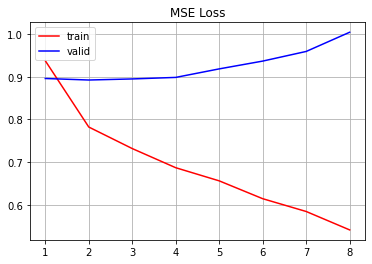


**************************************************

mobilenet Features, Fold: 3, HL: [64]

**************************************************

Building Model ...

1280 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96123 | Valid Loss: 0.89756 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.76392 | Valid Loss: 0.91391 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.71403 | Valid Loss: 0.88494 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.66417 | Valid Loss: 0.90727 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.61093 | Valid Loss: 0.94426 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.56015 | Valid Loss: 0.94780 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.51142 | Valid Loss: 0.98620 | Time: 0.57 seconds
Epoch: 8 | Train Loss: 0.44938 | Valid Loss: 1.02245 | Time: 0.58 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Epo

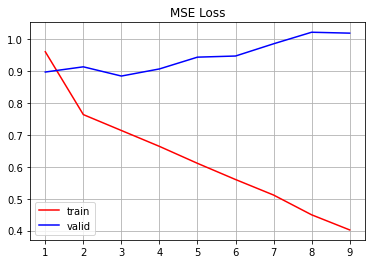


**************************************************

mobilenet Features, Fold: 3, HL: [128]

**************************************************

Building Model ...

1280 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.00465 | Valid Loss: 0.92204 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.76038 | Valid Loss: 0.91346 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.70066 | Valid Loss: 0.91393 | Time: 0.72 seconds
Epoch: 4 | Train Loss: 0.63211 | Valid Loss: 0.92670 | Time: 0.73 seconds
Epoch: 5 | Train Loss: 0.58706 | Valid Loss: 0.93163 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.54023 | Valid Loss: 1.00377 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.46649 | Valid Loss: 1.04372 | Time: 0.61 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

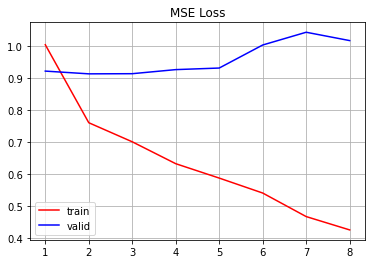


**************************************************

mobilenet Features, Fold: 3, HL: [256]

**************************************************

Building Model ...

1280 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.03875 | Valid Loss: 0.94505 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.76606 | Valid Loss: 0.90872 | Time: 0.67 seconds
Epoch: 3 | Train Loss: 0.69091 | Valid Loss: 0.93298 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.62751 | Valid Loss: 0.92291 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.57806 | Valid Loss: 0.93830 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.51520 | Valid Loss: 0.97794 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.45634 | Valid Loss: 1.00817 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

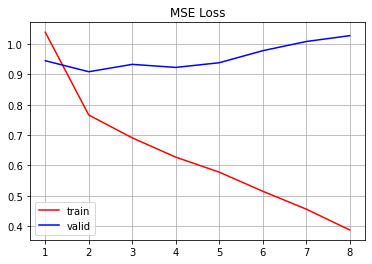


**************************************************

mobilenet Features, Fold: 3, HL: [512]

**************************************************

Building Model ...

1280 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.22681 | Valid Loss: 1.02863 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.75534 | Valid Loss: 0.99867 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.64645 | Valid Loss: 1.01787 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.57976 | Valid Loss: 0.96308 | Time: 0.80 seconds
Epoch: 5 | Train Loss: 0.51668 | Valid Loss: 1.00690 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.44791 | Valid Loss: 1.02868 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.39057 | Valid Loss: 1.03229 | Time: 0.60 seconds
Epoch: 8 | Train Loss: 0.33843 | Valid Loss: 1.05562 | Time: 0.59 seconds
Epoch: 9 | Train Loss: 0.30092 | Valid Loss: 1.03745 | Time: 0.57 seconds

Early Stopping at Epoch 9

***

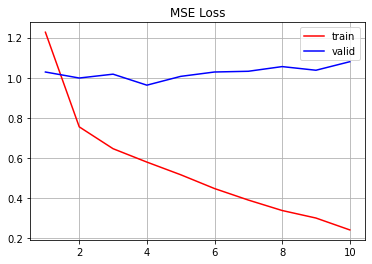


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

mobilenet Features, Fold: 4, HL: []

**************************************************

Building Model ...

1280 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97743 | Valid Loss: 0.95845 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.85639 | Valid Loss: 0.94485 | Time: 0.44 seconds
Epoch: 3 | Train Loss: 0.82950 | Valid Loss: 0.92977 | Time: 0.43 seconds
Epoch: 4 | Train Loss: 0.81134 | Valid Loss: 0.91337 | Time: 0.43 seconds
Epoch: 5 | Train Loss: 0.79889 | Valid Loss: 0.91179 | Time: 0.44 seconds
Epoch: 6 | Train Loss: 0.79286 | Valid Loss: 0.90459 | Time: 0.46 seconds
Epoch: 7 | Train Loss: 0.78834 | Valid Loss: 0.91094 | Time: 0.62 seconds
Epoch: 8 | Train Loss: 0.78376 | Valid Loss: 0.90516 | Time: 0.54 seconds
Epoch: 9 | T

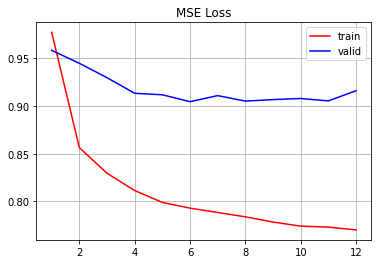


**************************************************

mobilenet Features, Fold: 4, HL: [32]

**************************************************

Building Model ...

1280 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.95010 | Valid Loss: 0.92110 | Time: 0.57 seconds
Epoch: 2 | Train Loss: 0.78212 | Valid Loss: 0.90614 | Time: 0.78 seconds
Epoch: 3 | Train Loss: 0.73568 | Valid Loss: 0.90267 | Time: 0.62 seconds
Epoch: 4 | Train Loss: 0.69179 | Valid Loss: 0.90545 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.65141 | Valid Loss: 0.93057 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.60342 | Valid Loss: 0.95749 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.56583 | Valid Loss: 0.98664 | Time: 0.57 seconds
Epoch: 8 | Train Loss: 0.51776 | Valid Loss: 1.02265 | Time: 0.57 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Epo

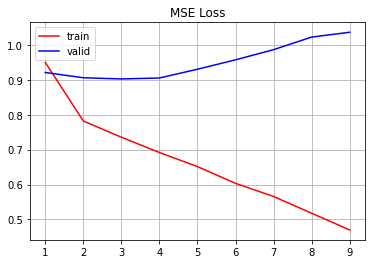


**************************************************

mobilenet Features, Fold: 4, HL: [64]

**************************************************

Building Model ...

1280 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.95693 | Valid Loss: 0.92438 | Time: 0.57 seconds
Epoch: 2 | Train Loss: 0.76765 | Valid Loss: 0.89498 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.70997 | Valid Loss: 0.94979 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.66948 | Valid Loss: 0.97563 | Time: 0.56 seconds
Epoch: 5 | Train Loss: 0.63116 | Valid Loss: 0.93598 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.56660 | Valid Loss: 1.01920 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.52641 | Valid Loss: 1.00691 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Ep

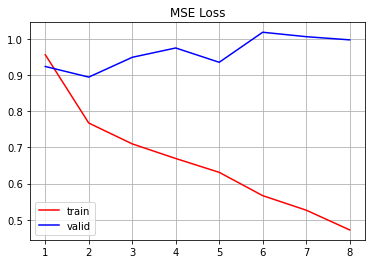


**************************************************

mobilenet Features, Fold: 4, HL: [128]

**************************************************

Building Model ...

1280 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.02227 | Valid Loss: 0.94240 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.78222 | Valid Loss: 0.93877 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.71624 | Valid Loss: 0.93600 | Time: 0.77 seconds
Epoch: 4 | Train Loss: 0.65201 | Valid Loss: 0.96509 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.59864 | Valid Loss: 0.96582 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.54225 | Valid Loss: 1.00954 | Time: 0.62 seconds
Epoch: 7 | Train Loss: 0.48760 | Valid Loss: 1.04587 | Time: 0.57 seconds
Epoch: 8 | Train Loss: 0.43331 | Valid Loss: 1.07747 | Time: 0.57 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at E

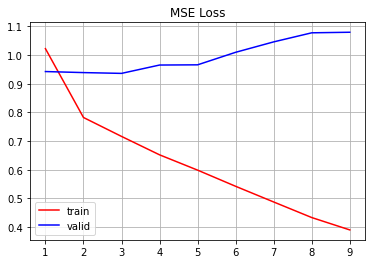


**************************************************

mobilenet Features, Fold: 4, HL: [256]

**************************************************

Building Model ...

1280 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06967 | Valid Loss: 0.95816 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.76069 | Valid Loss: 0.99237 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.69062 | Valid Loss: 0.94579 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.62603 | Valid Loss: 0.99223 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.56789 | Valid Loss: 1.00234 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.50068 | Valid Loss: 1.00709 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.43817 | Valid Loss: 1.05152 | Time: 0.58 seconds
Epoch: 8 | Train Loss: 0.39535 | Valid Loss: 1.15235 | Time: 0.57 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at E

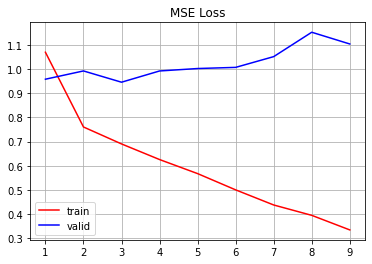


**************************************************

mobilenet Features, Fold: 4, HL: [512]

**************************************************

Building Model ...

1280 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.22361 | Valid Loss: 1.07390 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.77385 | Valid Loss: 0.98016 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.67476 | Valid Loss: 0.99833 | Time: 0.76 seconds
Epoch: 4 | Train Loss: 0.59729 | Valid Loss: 1.02158 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.53641 | Valid Loss: 1.02468 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.47132 | Valid Loss: 1.05885 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.42499 | Valid Loss: 1.11724 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

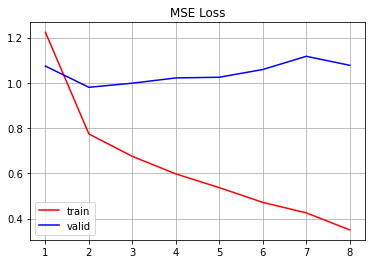


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

mobilenet Features, Fold: 5, HL: []

**************************************************

Building Model ...

1280 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98296 | Valid Loss: 0.84362 | Time: 0.43 seconds
Epoch: 2 | Train Loss: 0.85824 | Valid Loss: 0.83114 | Time: 0.43 seconds
Epoch: 3 | Train Loss: 0.83133 | Valid Loss: 0.83126 | Time: 0.43 seconds
Epoch: 4 | Train Loss: 0.81370 | Valid Loss: 0.80145 | Time: 0.43 seconds
Epoch: 5 | Train Loss: 0.79836 | Valid Loss: 0.81058 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.79511 | Valid Loss: 0.80279 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.78841 | Valid Loss: 0.80152 | Time: 0.43 seconds
Epoch: 8 | Train Loss: 0.78316 | Valid Loss: 0.79962 | Time: 0.43 seconds
Epoch: 9 | T

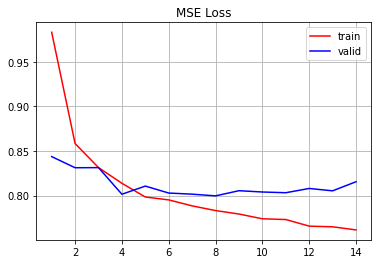


**************************************************

mobilenet Features, Fold: 5, HL: [32]

**************************************************

Building Model ...

1280 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.95039 | Valid Loss: 0.79545 | Time: 0.73 seconds
Epoch: 2 | Train Loss: 0.77387 | Valid Loss: 0.79376 | Time: 0.65 seconds
Epoch: 3 | Train Loss: 0.73666 | Valid Loss: 0.80181 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.68395 | Valid Loss: 0.82094 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.64461 | Valid Loss: 0.85182 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.60896 | Valid Loss: 0.86746 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.55753 | Valid Loss: 0.90436 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Ep

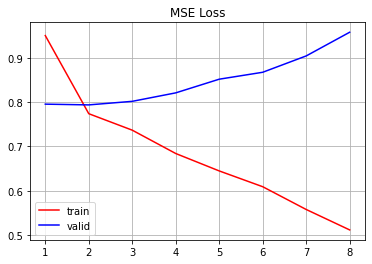


**************************************************

mobilenet Features, Fold: 5, HL: [64]

**************************************************

Building Model ...

1280 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.95538 | Valid Loss: 0.83279 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.77036 | Valid Loss: 0.80770 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.71872 | Valid Loss: 0.83939 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.66595 | Valid Loss: 0.85476 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.62200 | Valid Loss: 0.88307 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.55982 | Valid Loss: 0.88677 | Time: 0.57 seconds
Epoch: 7 | Train Loss: 0.50345 | Valid Loss: 0.89759 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Ep

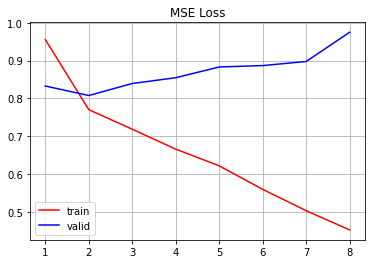


**************************************************

mobilenet Features, Fold: 5, HL: [128]

**************************************************

Building Model ...

1280 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.03826 | Valid Loss: 0.82115 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.77311 | Valid Loss: 0.82731 | Time: 0.63 seconds
Epoch: 3 | Train Loss: 0.69447 | Valid Loss: 0.84662 | Time: 0.77 seconds
Epoch: 4 | Train Loss: 0.65538 | Valid Loss: 0.87569 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.59209 | Valid Loss: 0.90104 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.53315 | Valid Loss: 0.90729 | Time: 0.57 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

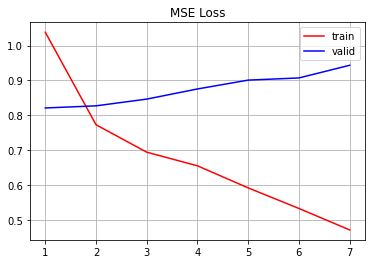


**************************************************

mobilenet Features, Fold: 5, HL: [256]

**************************************************

Building Model ...

1280 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06571 | Valid Loss: 0.85100 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.76607 | Valid Loss: 0.82773 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.67935 | Valid Loss: 0.87410 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.62548 | Valid Loss: 0.87822 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.55705 | Valid Loss: 0.89167 | Time: 0.57 seconds
Epoch: 6 | Train Loss: 0.50531 | Valid Loss: 0.93511 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.44300 | Valid Loss: 0.95045 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

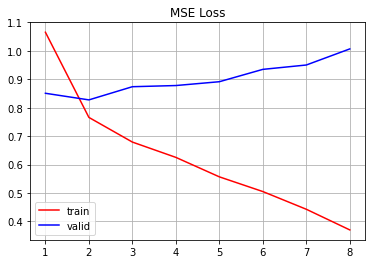


**************************************************

mobilenet Features, Fold: 5, HL: [512]

**************************************************

Building Model ...

1280 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.21935 | Valid Loss: 0.91246 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.76805 | Valid Loss: 0.88298 | Time: 0.63 seconds
Epoch: 3 | Train Loss: 0.65960 | Valid Loss: 0.91928 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.59811 | Valid Loss: 0.92020 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.51741 | Valid Loss: 0.95167 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.45243 | Valid Loss: 0.92981 | Time: 0.74 seconds
Epoch: 7 | Train Loss: 0.39610 | Valid Loss: 1.02275 | Time: 0.57 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 

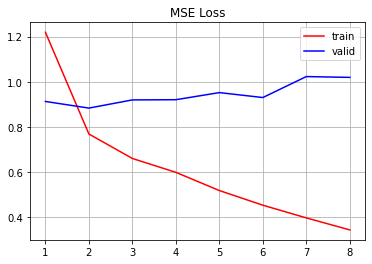

---
---
---
Loading Data ...

**************************************************

Splitting into Train and Validation Sets ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

densenet Features, Fold: 1, HL: []

**************************************************

Building Model ...

1664 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.87922 | Valid Loss: 0.84970 | Time: 0.53 seconds
Epoch: 2 | Train Loss: 0.80121 | Valid Loss: 0.83984 | Time: 0.68 seconds
Epoch: 3 | Train Loss: 0.78126 | Valid Loss: 0.83349 | Time: 0.53 seconds
Epoch: 4 | Train Loss: 0.77053 | Valid Loss: 0.82499 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.76294 | Valid Loss: 0.83449 | Time: 0.44 seconds
Epoch: 6 | Train Loss: 0.75044 | Valid Loss: 0.82515 | Time: 0.44 seconds
Epoch: 7 | Train Loss: 0.74712 | V

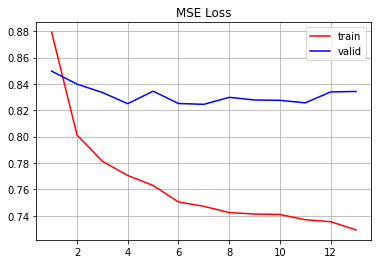


**************************************************

densenet Features, Fold: 1, HL: [32]

**************************************************

Building Model ...

1664 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.92275 | Valid Loss: 0.85914 | Time: 0.78 seconds
Epoch: 2 | Train Loss: 0.73081 | Valid Loss: 0.85734 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.67903 | Valid Loss: 0.85932 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.61596 | Valid Loss: 0.89604 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.57346 | Valid Loss: 0.89673 | Time: 0.63 seconds
Epoch: 6 | Train Loss: 0.50316 | Valid Loss: 0.91447 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.44899 | Valid Loss: 0.95622 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

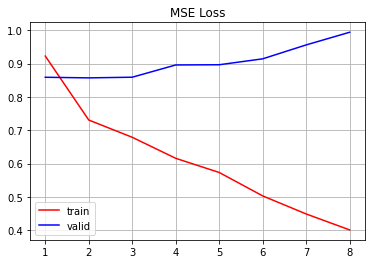


**************************************************

densenet Features, Fold: 1, HL: [64]

**************************************************

Building Model ...

1664 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.95292 | Valid Loss: 0.86542 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.72349 | Valid Loss: 0.85622 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.66454 | Valid Loss: 0.85787 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.59756 | Valid Loss: 0.90091 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.53979 | Valid Loss: 0.91418 | Time: 0.66 seconds
Epoch: 6 | Train Loss: 0.47837 | Valid Loss: 0.94920 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.40167 | Valid Loss: 0.96401 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

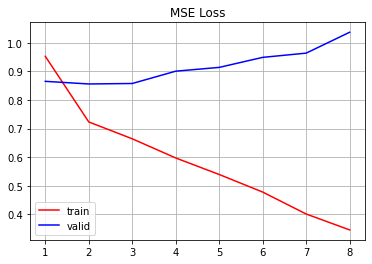


**************************************************

densenet Features, Fold: 1, HL: [128]

**************************************************

Building Model ...

1664 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96349 | Valid Loss: 0.87525 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.71769 | Valid Loss: 0.86626 | Time: 0.79 seconds
Epoch: 3 | Train Loss: 0.63804 | Valid Loss: 0.88276 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.57123 | Valid Loss: 0.91075 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.49493 | Valid Loss: 0.91078 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.40881 | Valid Loss: 1.00864 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.32795 | Valid Loss: 1.00470 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

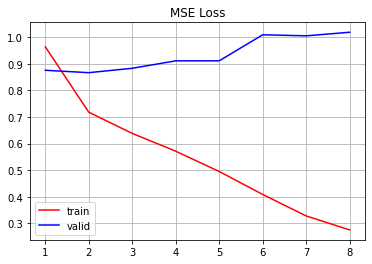


**************************************************

densenet Features, Fold: 1, HL: [256]

**************************************************

Building Model ...

1664 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.10936 | Valid Loss: 0.90467 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.71922 | Valid Loss: 0.89986 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.63406 | Valid Loss: 0.91045 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.54703 | Valid Loss: 0.93505 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.46300 | Valid Loss: 0.94302 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.37254 | Valid Loss: 0.99592 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.30215 | Valid Loss: 1.00602 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

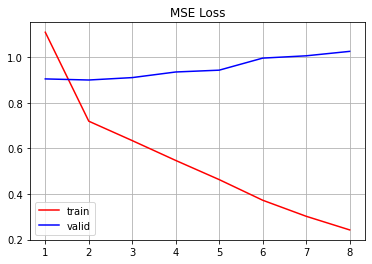


**************************************************

densenet Features, Fold: 1, HL: [512]

**************************************************

Building Model ...

1664 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.23847 | Valid Loss: 0.96655 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.72056 | Valid Loss: 0.96356 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.59357 | Valid Loss: 0.95871 | Time: 0.79 seconds
Epoch: 4 | Train Loss: 0.50108 | Valid Loss: 0.97227 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.41687 | Valid Loss: 0.96382 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.32662 | Valid Loss: 1.06502 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.26793 | Valid Loss: 0.99867 | Time: 0.61 seconds
Epoch: 8 | Train Loss: 0.21459 | Valid Loss: 1.05920 | Time: 0.61 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Ep

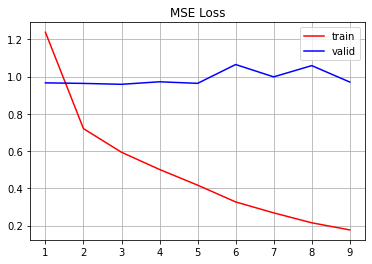


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

densenet Features, Fold: 2, HL: []

**************************************************

Building Model ...

1664 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.87242 | Valid Loss: 0.74231 | Time: 0.56 seconds
Epoch: 2 | Train Loss: 0.79957 | Valid Loss: 0.74089 | Time: 0.44 seconds
Epoch: 3 | Train Loss: 0.78128 | Valid Loss: 0.73177 | Time: 0.44 seconds
Epoch: 4 | Train Loss: 0.76642 | Valid Loss: 0.73746 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.75715 | Valid Loss: 0.74457 | Time: 0.43 seconds
Epoch: 6 | Train Loss: 0.74928 | Valid Loss: 0.74398 | Time: 0.44 seconds
Epoch: 7 | Train Loss: 0.74622 | Valid Loss: 0.74625 | Time: 0.44 seconds
Epoch: 8 | Train Loss: 0.73904 | Valid Loss: 0.74572 | Time: 0.44 seconds

Early Stoppi

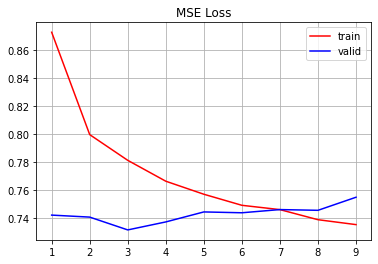


**************************************************

densenet Features, Fold: 2, HL: [32]

**************************************************

Building Model ...

1664 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.92242 | Valid Loss: 0.74844 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.73834 | Valid Loss: 0.76233 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.68167 | Valid Loss: 0.76835 | Time: 0.62 seconds
Epoch: 4 | Train Loss: 0.63751 | Valid Loss: 0.77272 | Time: 0.85 seconds
Epoch: 5 | Train Loss: 0.58269 | Valid Loss: 0.82927 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.52750 | Valid Loss: 0.84372 | Time: 0.63 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

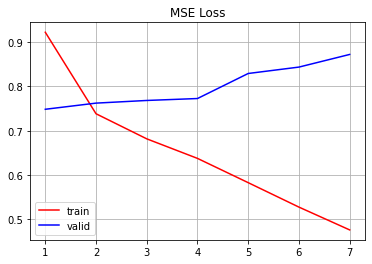


**************************************************

densenet Features, Fold: 2, HL: [64]

**************************************************

Building Model ...

1664 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94424 | Valid Loss: 0.75640 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.73315 | Valid Loss: 0.76380 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.67644 | Valid Loss: 0.77059 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.61522 | Valid Loss: 0.79657 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.55540 | Valid Loss: 0.83237 | Time: 0.65 seconds
Epoch: 6 | Train Loss: 0.49997 | Valid Loss: 0.84032 | Time: 0.58 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

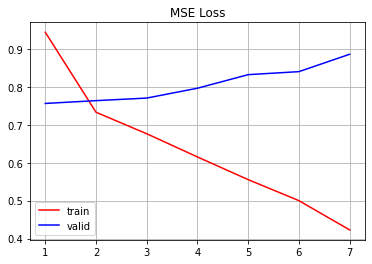


**************************************************

densenet Features, Fold: 2, HL: [128]

**************************************************

Building Model ...

1664 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97010 | Valid Loss: 0.80726 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.71696 | Valid Loss: 0.78252 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.64789 | Valid Loss: 0.79051 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.56537 | Valid Loss: 0.82958 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.49964 | Valid Loss: 0.85612 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.42421 | Valid Loss: 0.86155 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.34643 | Valid Loss: 0.90077 | Time: 0.75 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

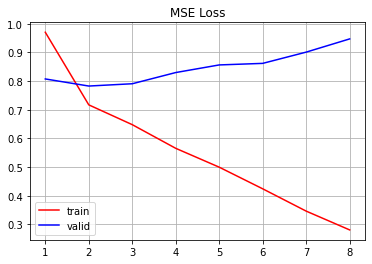


**************************************************

densenet Features, Fold: 2, HL: [256]

**************************************************

Building Model ...

1664 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.09096 | Valid Loss: 0.77678 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.71639 | Valid Loss: 0.79764 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.61422 | Valid Loss: 0.81175 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.53399 | Valid Loss: 0.85420 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.44554 | Valid Loss: 0.86446 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.36603 | Valid Loss: 0.91961 | Time: 0.58 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************


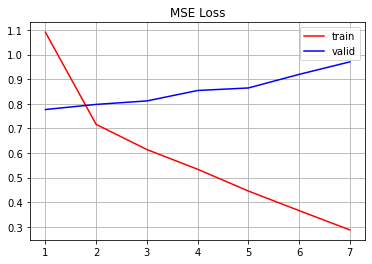


**************************************************

densenet Features, Fold: 2, HL: [512]

**************************************************

Building Model ...

1664 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.19998 | Valid Loss: 0.85332 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.72243 | Valid Loss: 0.82562 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.62871 | Valid Loss: 0.84250 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.53468 | Valid Loss: 0.89284 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.42855 | Valid Loss: 0.89222 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.34799 | Valid Loss: 0.92064 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.26777 | Valid Loss: 0.92141 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

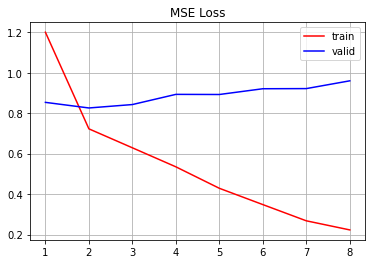


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

densenet Features, Fold: 3, HL: []

**************************************************

Building Model ...

1664 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.87063 | Valid Loss: 0.85693 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.79112 | Valid Loss: 0.85036 | Time: 0.48 seconds
Epoch: 3 | Train Loss: 0.77333 | Valid Loss: 0.85992 | Time: 0.44 seconds
Epoch: 4 | Train Loss: 0.76011 | Valid Loss: 0.86088 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.75123 | Valid Loss: 0.85762 | Time: 0.44 seconds
Epoch: 6 | Train Loss: 0.74353 | Valid Loss: 0.86381 | Time: 0.44 seconds
Epoch: 7 | Train Loss: 0.73931 | Valid Loss: 0.85922 | Time: 0.62 seconds

Early Stopping at Epoch 7

**************************************************

Best Va

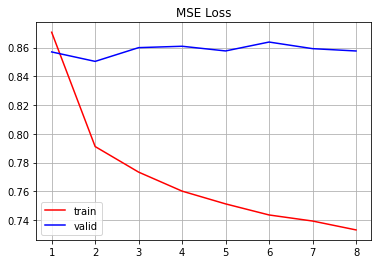


**************************************************

densenet Features, Fold: 3, HL: [32]

**************************************************

Building Model ...

1664 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.90360 | Valid Loss: 0.86332 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.73585 | Valid Loss: 0.86660 | Time: 0.57 seconds
Epoch: 3 | Train Loss: 0.67076 | Valid Loss: 0.86982 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.62670 | Valid Loss: 0.89420 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.57170 | Valid Loss: 0.91358 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.50920 | Valid Loss: 0.92190 | Time: 0.57 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

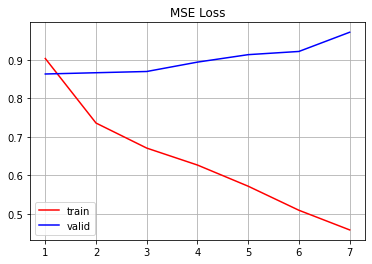


**************************************************

densenet Features, Fold: 3, HL: [64]

**************************************************

Building Model ...

1664 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94350 | Valid Loss: 0.89871 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.71474 | Valid Loss: 0.89402 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.65332 | Valid Loss: 0.89239 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.59833 | Valid Loss: 0.94034 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.53895 | Valid Loss: 0.93397 | Time: 0.85 seconds
Epoch: 6 | Train Loss: 0.47242 | Valid Loss: 0.94926 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.40838 | Valid Loss: 0.97785 | Time: 0.58 seconds
Epoch: 8 | Train Loss: 0.35480 | Valid Loss: 1.00769 | Time: 0.58 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Epoc

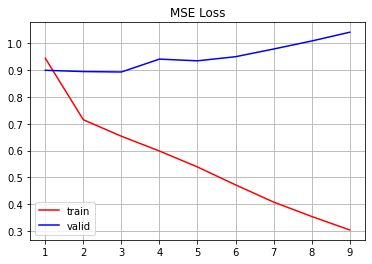


**************************************************

densenet Features, Fold: 3, HL: [128]

**************************************************

Building Model ...

1664 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97434 | Valid Loss: 0.87449 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.70393 | Valid Loss: 0.87831 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.62181 | Valid Loss: 0.93535 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.56300 | Valid Loss: 0.90922 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.47305 | Valid Loss: 0.93638 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.39202 | Valid Loss: 0.95333 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************


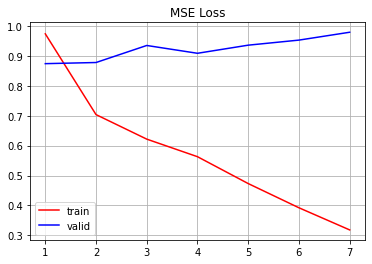


**************************************************

densenet Features, Fold: 3, HL: [256]

**************************************************

Building Model ...

1664 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.08546 | Valid Loss: 0.92948 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.71219 | Valid Loss: 0.89932 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.61872 | Valid Loss: 0.92685 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.52709 | Valid Loss: 0.93715 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.44919 | Valid Loss: 0.98819 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.36876 | Valid Loss: 0.97092 | Time: 0.75 seconds
Epoch: 7 | Train Loss: 0.29800 | Valid Loss: 0.98750 | Time: 0.62 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

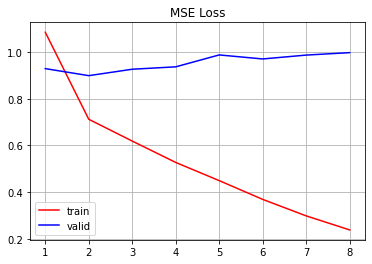


**************************************************

densenet Features, Fold: 3, HL: [512]

**************************************************

Building Model ...

1664 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.20869 | Valid Loss: 0.92433 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.71290 | Valid Loss: 0.93637 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.60753 | Valid Loss: 0.94536 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.51153 | Valid Loss: 0.93957 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.41060 | Valid Loss: 0.97974 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.34418 | Valid Loss: 1.00911 | Time: 0.61 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************


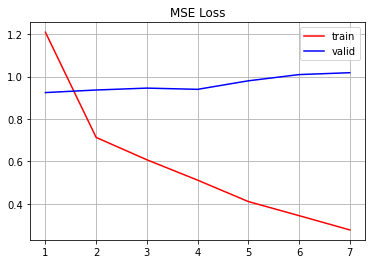


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

densenet Features, Fold: 4, HL: []

**************************************************

Building Model ...

1664 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.87993 | Valid Loss: 0.89283 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.79847 | Valid Loss: 0.87641 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.77745 | Valid Loss: 0.88856 | Time: 0.47 seconds
Epoch: 4 | Train Loss: 0.76486 | Valid Loss: 0.89666 | Time: 0.45 seconds
Epoch: 5 | Train Loss: 0.75582 | Valid Loss: 0.89505 | Time: 0.44 seconds
Epoch: 6 | Train Loss: 0.74945 | Valid Loss: 0.90212 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.74020 | Valid Loss: 0.90251 | Time: 0.45 seconds

Early Stopping at Epoch 7

**************************************************

Best Va

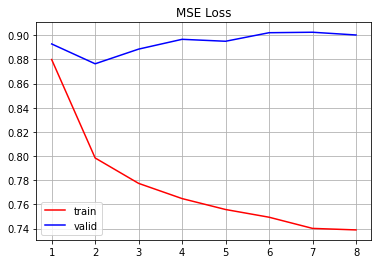


**************************************************

densenet Features, Fold: 4, HL: [32]

**************************************************

Building Model ...

1664 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.92444 | Valid Loss: 0.86360 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.74280 | Valid Loss: 0.87690 | Time: 0.75 seconds
Epoch: 3 | Train Loss: 0.67614 | Valid Loss: 0.90543 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.63284 | Valid Loss: 0.92750 | Time: 0.64 seconds
Epoch: 5 | Train Loss: 0.57985 | Valid Loss: 0.95585 | Time: 0.87 seconds
Epoch: 6 | Train Loss: 0.51816 | Valid Loss: 0.98313 | Time: 0.61 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.08 minutes

**************************************************

T

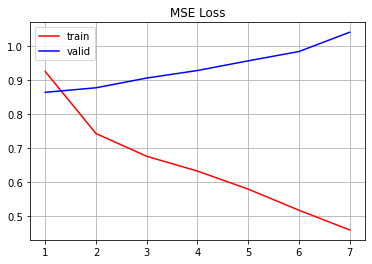


**************************************************

densenet Features, Fold: 4, HL: [64]

**************************************************

Building Model ...

1664 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96176 | Valid Loss: 0.88494 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.72875 | Valid Loss: 0.89950 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.65630 | Valid Loss: 0.92290 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.58862 | Valid Loss: 0.97663 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.53161 | Valid Loss: 1.01972 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.46972 | Valid Loss: 0.99851 | Time: 0.58 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

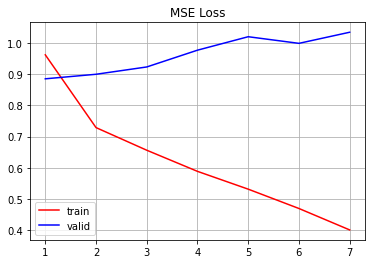


**************************************************

densenet Features, Fold: 4, HL: [128]

**************************************************

Building Model ...

1664 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96129 | Valid Loss: 0.90828 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.71135 | Valid Loss: 0.94890 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.63338 | Valid Loss: 0.97762 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.56656 | Valid Loss: 0.95184 | Time: 0.76 seconds
Epoch: 5 | Train Loss: 0.48928 | Valid Loss: 1.00736 | Time: 0.73 seconds
Epoch: 6 | Train Loss: 0.41365 | Valid Loss: 1.04372 | Time: 0.60 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************


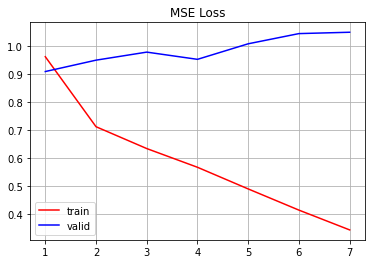


**************************************************

densenet Features, Fold: 4, HL: [256]

**************************************************

Building Model ...

1664 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.09555 | Valid Loss: 0.95055 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.72127 | Valid Loss: 0.94248 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.62364 | Valid Loss: 0.95867 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.53631 | Valid Loss: 0.97668 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.45530 | Valid Loss: 1.05399 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.36791 | Valid Loss: 1.01662 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.29325 | Valid Loss: 1.07778 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

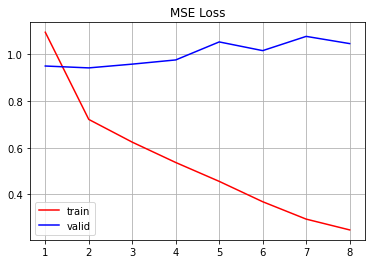


**************************************************

densenet Features, Fold: 4, HL: [512]

**************************************************

Building Model ...

1664 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.24769 | Valid Loss: 0.98710 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.72690 | Valid Loss: 0.97053 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.61363 | Valid Loss: 0.97657 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.50586 | Valid Loss: 1.02592 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.43678 | Valid Loss: 0.99936 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.34650 | Valid Loss: 1.04513 | Time: 0.78 seconds
Epoch: 7 | Train Loss: 0.26975 | Valid Loss: 1.03212 | Time: 0.62 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

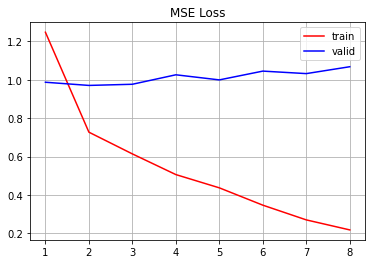


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

densenet Features, Fold: 5, HL: []

**************************************************

Building Model ...

1664 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.86910 | Valid Loss: 0.78437 | Time: 0.47 seconds
Epoch: 2 | Train Loss: 0.79593 | Valid Loss: 0.79174 | Time: 0.44 seconds
Epoch: 3 | Train Loss: 0.77571 | Valid Loss: 0.77985 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.76317 | Valid Loss: 0.78561 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.75368 | Valid Loss: 0.79343 | Time: 0.44 seconds
Epoch: 6 | Train Loss: 0.74591 | Valid Loss: 0.79077 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.74288 | Valid Loss: 0.79687 | Time: 0.44 seconds
Epoch: 8 | Train Loss: 0.73660 | Valid Loss: 0.79324 | Time: 0.44 seconds

Early Stoppi

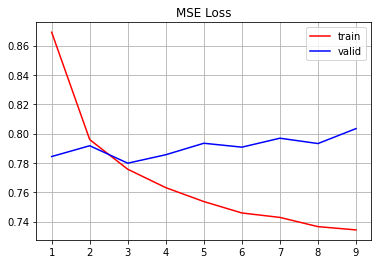


**************************************************

densenet Features, Fold: 5, HL: [32]

**************************************************

Building Model ...

1664 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.90370 | Valid Loss: 0.79754 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.72713 | Valid Loss: 0.81790 | Time: 0.58 seconds
Epoch: 3 | Train Loss: 0.68215 | Valid Loss: 0.83172 | Time: 0.57 seconds
Epoch: 4 | Train Loss: 0.61698 | Valid Loss: 0.85146 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.56342 | Valid Loss: 0.89265 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.51117 | Valid Loss: 0.89114 | Time: 0.63 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

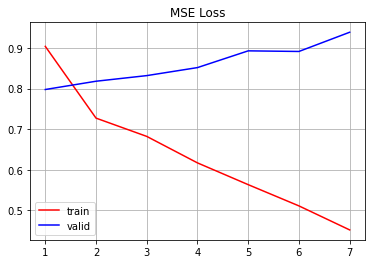


**************************************************

densenet Features, Fold: 5, HL: [64]

**************************************************

Building Model ...

1664 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94856 | Valid Loss: 0.81288 | Time: 0.73 seconds
Epoch: 2 | Train Loss: 0.72520 | Valid Loss: 0.80538 | Time: 0.74 seconds
Epoch: 3 | Train Loss: 0.65591 | Valid Loss: 0.85594 | Time: 0.86 seconds
Epoch: 4 | Train Loss: 0.59053 | Valid Loss: 0.87881 | Time: 0.66 seconds
Epoch: 5 | Train Loss: 0.51908 | Valid Loss: 0.87759 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.45848 | Valid Loss: 0.94506 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.38497 | Valid Loss: 0.95919 | Time: 0.61 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

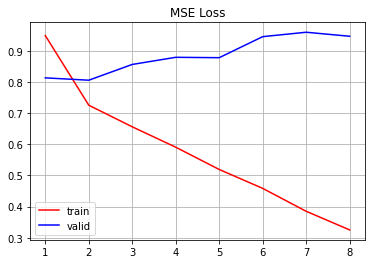


**************************************************

densenet Features, Fold: 5, HL: [128]

**************************************************

Building Model ...

1664 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97982 | Valid Loss: 0.82145 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.71256 | Valid Loss: 0.81760 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.63995 | Valid Loss: 0.84541 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.56645 | Valid Loss: 0.87794 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.48801 | Valid Loss: 0.91334 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.40851 | Valid Loss: 0.92028 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.33430 | Valid Loss: 0.98505 | Time: 0.68 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

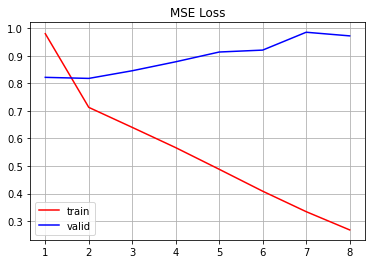


**************************************************

densenet Features, Fold: 5, HL: [256]

**************************************************

Building Model ...

1664 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.09071 | Valid Loss: 0.84625 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.71210 | Valid Loss: 0.84621 | Time: 0.83 seconds
Epoch: 3 | Train Loss: 0.62119 | Valid Loss: 0.86202 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.53555 | Valid Loss: 0.93288 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.46875 | Valid Loss: 0.91738 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.37135 | Valid Loss: 0.92803 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.29215 | Valid Loss: 0.95856 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

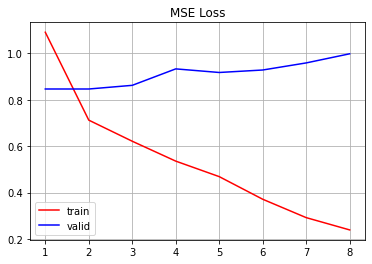


**************************************************

densenet Features, Fold: 5, HL: [512]

**************************************************

Building Model ...

1664 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.27762 | Valid Loss: 0.92372 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.71503 | Valid Loss: 0.88712 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.59329 | Valid Loss: 0.94316 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.50159 | Valid Loss: 0.90571 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.40580 | Valid Loss: 1.00554 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.33072 | Valid Loss: 0.96551 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.27193 | Valid Loss: 0.98155 | Time: 0.58 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 E

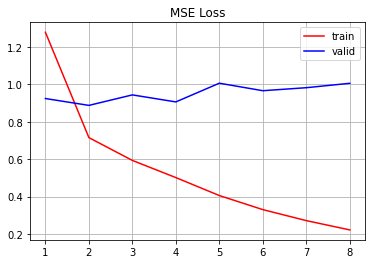

---
---
---
Loading Data ...

**************************************************

Splitting into Train and Validation Sets ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

resnet Features, Fold: 1, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.93846 | Valid Loss: 0.89676 | Time: 0.46 seconds
Epoch: 2 | Train Loss: 0.83851 | Valid Loss: 0.87820 | Time: 0.47 seconds
Epoch: 3 | Train Loss: 0.81043 | Valid Loss: 0.88673 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.79475 | Valid Loss: 0.88586 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.78220 | Valid Loss: 0.87574 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.77309 | Valid Loss: 0.87471 | Time: 0.44 seconds
Epoch: 7 | Train Loss: 0.77043 | Val

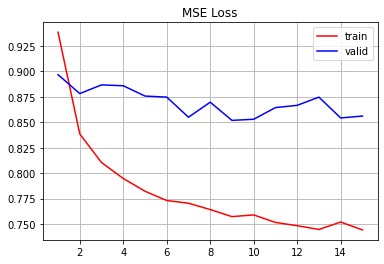


**************************************************

resnet Features, Fold: 1, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.90212 | Valid Loss: 0.85844 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.77233 | Valid Loss: 0.85749 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.73087 | Valid Loss: 0.86988 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.69520 | Valid Loss: 0.87267 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.66663 | Valid Loss: 0.87316 | Time: 0.75 seconds
Epoch: 6 | Train Loss: 0.62366 | Valid Loss: 0.89047 | Time: 1.08 seconds
Epoch: 7 | Train Loss: 0.59211 | Valid Loss: 0.92716 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epoch

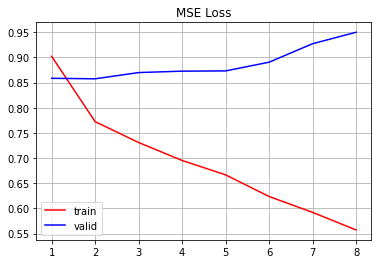


**************************************************

resnet Features, Fold: 1, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94048 | Valid Loss: 0.85078 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.76389 | Valid Loss: 0.85113 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.72199 | Valid Loss: 0.89050 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.67888 | Valid Loss: 0.87053 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.64307 | Valid Loss: 0.89307 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.60575 | Valid Loss: 0.91011 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Tra

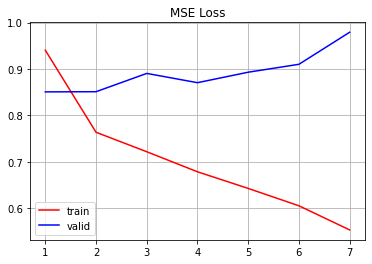


**************************************************

resnet Features, Fold: 1, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06050 | Valid Loss: 0.91900 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.77435 | Valid Loss: 0.90450 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.71405 | Valid Loss: 0.90745 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.66852 | Valid Loss: 0.88278 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.62167 | Valid Loss: 0.92362 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.57565 | Valid Loss: 0.93147 | Time: 0.65 seconds
Epoch: 7 | Train Loss: 0.52706 | Valid Loss: 0.95631 | Time: 0.75 seconds
Epoch: 8 | Train Loss: 0.47050 | Valid Loss: 0.96408 | Time: 0.59 seconds
Epoch: 9 | Train Loss: 0.44486 | Valid Loss: 1.01347 | Time: 0.59 seconds

Early Stopping at Epoch 9

******

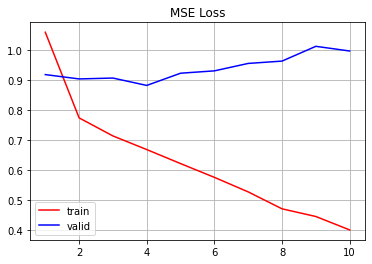


**************************************************

resnet Features, Fold: 1, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.08993 | Valid Loss: 0.93033 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.77409 | Valid Loss: 0.89740 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.70452 | Valid Loss: 0.93466 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.66104 | Valid Loss: 0.91070 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.61435 | Valid Loss: 0.92167 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.55730 | Valid Loss: 0.96262 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.51060 | Valid Loss: 0.98760 | Time: 0.62 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

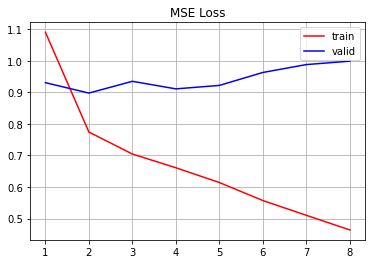


**************************************************

resnet Features, Fold: 1, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.32815 | Valid Loss: 0.95950 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.80099 | Valid Loss: 0.92017 | Time: 0.63 seconds
Epoch: 3 | Train Loss: 0.70157 | Valid Loss: 0.95424 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.62984 | Valid Loss: 0.99721 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.57949 | Valid Loss: 0.97919 | Time: 0.67 seconds
Epoch: 6 | Train Loss: 0.53501 | Valid Loss: 0.97376 | Time: 0.69 seconds
Epoch: 7 | Train Loss: 0.47879 | Valid Loss: 0.98847 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

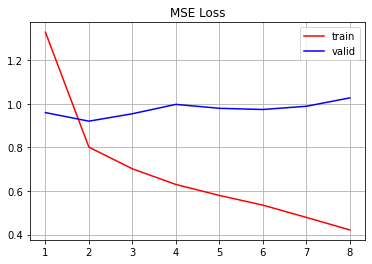


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

resnet Features, Fold: 2, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94144 | Valid Loss: 0.83139 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.83817 | Valid Loss: 0.77681 | Time: 0.46 seconds
Epoch: 3 | Train Loss: 0.80577 | Valid Loss: 0.77208 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.79419 | Valid Loss: 0.77853 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.77852 | Valid Loss: 0.75934 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.77149 | Valid Loss: 0.75853 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.77104 | Valid Loss: 0.77811 | Time: 0.44 seconds
Epoch: 8 | Train Loss: 0.76616 | Valid Loss: 0.77651 | Time: 0.45 seconds
Epoch: 9 | Trai

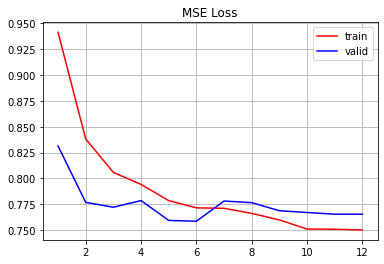


**************************************************

resnet Features, Fold: 2, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.88961 | Valid Loss: 0.76531 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.77340 | Valid Loss: 0.77373 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.73173 | Valid Loss: 0.77069 | Time: 0.62 seconds
Epoch: 4 | Train Loss: 0.70077 | Valid Loss: 0.78501 | Time: 0.72 seconds
Epoch: 5 | Train Loss: 0.67295 | Valid Loss: 0.79250 | Time: 1.06 seconds
Epoch: 6 | Train Loss: 0.63361 | Valid Loss: 0.81493 | Time: 0.63 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.08 minutes

**************************************************

Tra

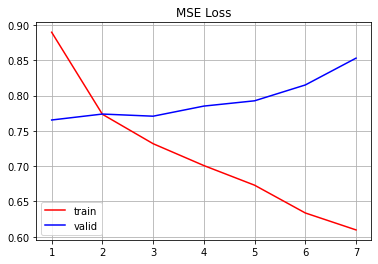


**************************************************

resnet Features, Fold: 2, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.93405 | Valid Loss: 0.78581 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.76124 | Valid Loss: 0.77009 | Time: 0.64 seconds
Epoch: 3 | Train Loss: 0.71472 | Valid Loss: 0.77767 | Time: 0.64 seconds
Epoch: 4 | Train Loss: 0.68181 | Valid Loss: 0.80283 | Time: 0.76 seconds
Epoch: 5 | Train Loss: 0.63572 | Valid Loss: 0.79790 | Time: 0.63 seconds
Epoch: 6 | Train Loss: 0.60267 | Valid Loss: 0.83726 | Time: 0.66 seconds
Epoch: 7 | Train Loss: 0.56971 | Valid Loss: 0.81690 | Time: 0.62 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epoch

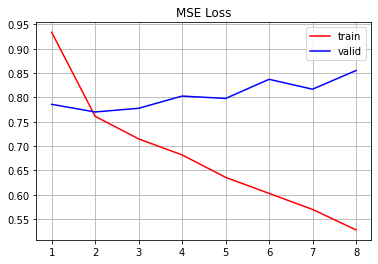


**************************************************

resnet Features, Fold: 2, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.03901 | Valid Loss: 0.84036 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.77440 | Valid Loss: 0.80221 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.70972 | Valid Loss: 0.78648 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.66646 | Valid Loss: 0.81085 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.61610 | Valid Loss: 0.84079 | Time: 0.63 seconds
Epoch: 6 | Train Loss: 0.56550 | Valid Loss: 0.84444 | Time: 0.79 seconds
Epoch: 7 | Train Loss: 0.52260 | Valid Loss: 0.86588 | Time: 0.62 seconds
Epoch: 8 | Train Loss: 0.47860 | Valid Loss: 0.88868 | Time: 0.61 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Epoc

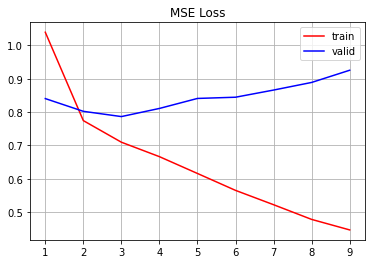


**************************************************

resnet Features, Fold: 2, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.12357 | Valid Loss: 0.85972 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.77979 | Valid Loss: 0.79812 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.70570 | Valid Loss: 0.83760 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.64667 | Valid Loss: 0.81704 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.59218 | Valid Loss: 0.85484 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.53509 | Valid Loss: 0.93418 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.49276 | Valid Loss: 0.87745 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

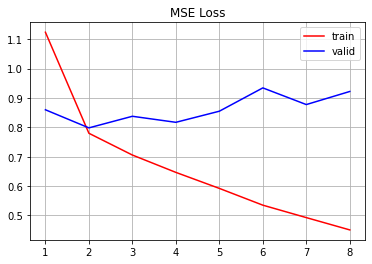


**************************************************

resnet Features, Fold: 2, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.27085 | Valid Loss: 0.85836 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.77617 | Valid Loss: 0.87816 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.70443 | Valid Loss: 0.87832 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.63456 | Valid Loss: 0.84810 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.57952 | Valid Loss: 0.90668 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.51882 | Valid Loss: 0.91693 | Time: 0.79 seconds
Epoch: 7 | Train Loss: 0.47285 | Valid Loss: 0.95085 | Time: 0.62 seconds
Epoch: 8 | Train Loss: 0.43143 | Valid Loss: 0.92793 | Time: 0.60 seconds
Epoch: 9 | Train Loss: 0.36844 | Valid Loss: 0.93127 | Time: 0.59 seconds

Early Stopping at Epoch 9

******

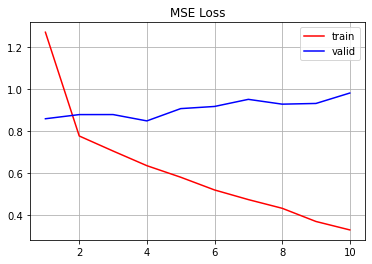


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

resnet Features, Fold: 3, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94904 | Valid Loss: 0.90295 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.83977 | Valid Loss: 0.88921 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.80564 | Valid Loss: 0.87748 | Time: 0.46 seconds
Epoch: 4 | Train Loss: 0.79647 | Valid Loss: 0.86666 | Time: 0.45 seconds
Epoch: 5 | Train Loss: 0.78178 | Valid Loss: 0.85901 | Time: 0.46 seconds
Epoch: 6 | Train Loss: 0.76937 | Valid Loss: 0.87208 | Time: 0.46 seconds
Epoch: 7 | Train Loss: 0.76444 | Valid Loss: 0.86471 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 0.76294 | Valid Loss: 0.87367 | Time: 0.48 seconds
Epoch: 9 | Trai

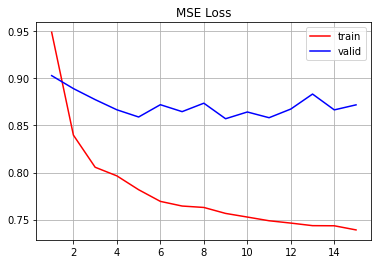


**************************************************

resnet Features, Fold: 3, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.89448 | Valid Loss: 0.86565 | Time: 0.89 seconds
Epoch: 2 | Train Loss: 0.76847 | Valid Loss: 0.86595 | Time: 0.65 seconds
Epoch: 3 | Train Loss: 0.73058 | Valid Loss: 0.86926 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.69977 | Valid Loss: 0.88520 | Time: 0.76 seconds
Epoch: 5 | Train Loss: 0.66293 | Valid Loss: 0.90038 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.63561 | Valid Loss: 0.92130 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.08 minutes

**************************************************

Tra

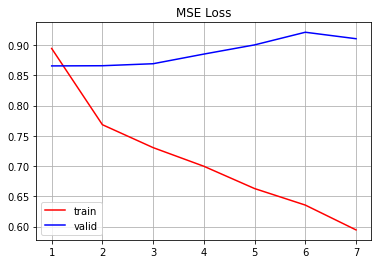


**************************************************

resnet Features, Fold: 3, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.95473 | Valid Loss: 0.86372 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.75865 | Valid Loss: 0.89442 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.71275 | Valid Loss: 0.86379 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.66609 | Valid Loss: 0.88437 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.63276 | Valid Loss: 0.89779 | Time: 0.58 seconds
Epoch: 6 | Train Loss: 0.59270 | Valid Loss: 0.94367 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Tra

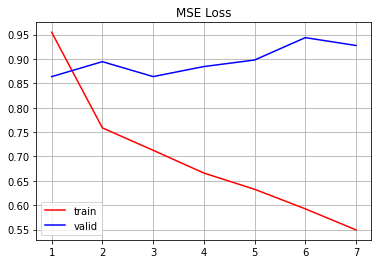


**************************************************

resnet Features, Fold: 3, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.07076 | Valid Loss: 0.90648 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.78389 | Valid Loss: 0.92166 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.70899 | Valid Loss: 0.92339 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.66433 | Valid Loss: 0.94504 | Time: 0.75 seconds
Epoch: 5 | Train Loss: 0.61388 | Valid Loss: 0.92145 | Time: 0.65 seconds
Epoch: 6 | Train Loss: 0.56798 | Valid Loss: 0.96168 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

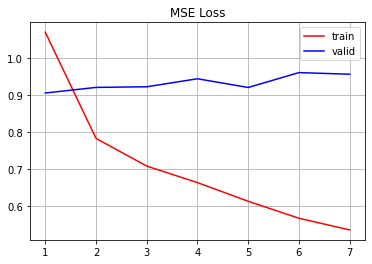


**************************************************

resnet Features, Fold: 3, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.10350 | Valid Loss: 0.95824 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.78135 | Valid Loss: 0.94898 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.71247 | Valid Loss: 0.94798 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.64383 | Valid Loss: 0.90658 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.59480 | Valid Loss: 0.95890 | Time: 0.62 seconds
Epoch: 6 | Train Loss: 0.54526 | Valid Loss: 0.97287 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.49582 | Valid Loss: 0.96294 | Time: 0.59 seconds
Epoch: 8 | Train Loss: 0.45075 | Valid Loss: 0.99788 | Time: 0.59 seconds
Epoch: 9 | Train Loss: 0.40521 | Valid Loss: 0.98775 | Time: 0.59 seconds

Early Stopping at Epoch 9

******

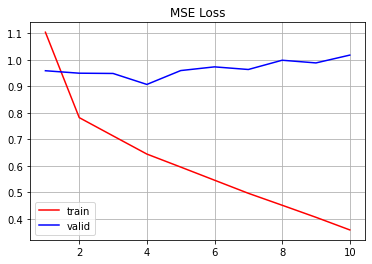


**************************************************

resnet Features, Fold: 3, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.24319 | Valid Loss: 0.93930 | Time: 0.64 seconds
Epoch: 2 | Train Loss: 0.79240 | Valid Loss: 0.93472 | Time: 0.65 seconds
Epoch: 3 | Train Loss: 0.70947 | Valid Loss: 0.95260 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.64941 | Valid Loss: 0.94170 | Time: 0.78 seconds
Epoch: 5 | Train Loss: 0.59422 | Valid Loss: 0.98538 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.54138 | Valid Loss: 0.97891 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.48372 | Valid Loss: 1.01521 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

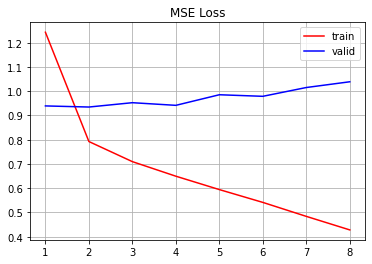


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

resnet Features, Fold: 4, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96050 | Valid Loss: 0.94688 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.84524 | Valid Loss: 0.90075 | Time: 0.47 seconds
Epoch: 3 | Train Loss: 0.81365 | Valid Loss: 0.88839 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.79637 | Valid Loss: 0.88791 | Time: 0.44 seconds
Epoch: 5 | Train Loss: 0.78397 | Valid Loss: 0.87647 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.77525 | Valid Loss: 0.87419 | Time: 0.44 seconds
Epoch: 7 | Train Loss: 0.77698 | Valid Loss: 0.86677 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 0.76680 | Valid Loss: 0.88204 | Time: 0.45 seconds
Epoch: 9 | Trai

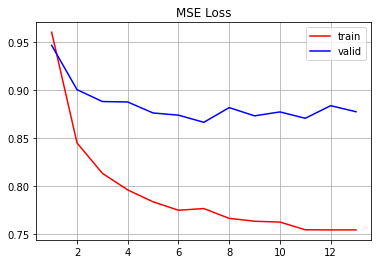


**************************************************

resnet Features, Fold: 4, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.90079 | Valid Loss: 0.88372 | Time: 0.69 seconds
Epoch: 2 | Train Loss: 0.77535 | Valid Loss: 0.89317 | Time: 0.85 seconds
Epoch: 3 | Train Loss: 0.73391 | Valid Loss: 0.88447 | Time: 0.68 seconds
Epoch: 4 | Train Loss: 0.69989 | Valid Loss: 0.88145 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.66974 | Valid Loss: 0.91824 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.63985 | Valid Loss: 0.93454 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.60571 | Valid Loss: 0.91796 | Time: 0.59 seconds
Epoch: 8 | Train Loss: 0.56992 | Valid Loss: 0.96149 | Time: 0.64 seconds
Epoch: 9 | Train Loss: 0.53669 | Valid Loss: 0.97495 | Time: 0.59 seconds

Early Stopping at Epoch 9

********

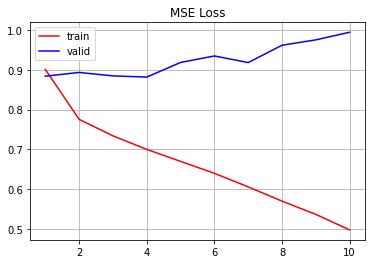


**************************************************

resnet Features, Fold: 4, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.96924 | Valid Loss: 0.90941 | Time: 0.59 seconds
Epoch: 2 | Train Loss: 0.77328 | Valid Loss: 0.87715 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.71247 | Valid Loss: 0.92416 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.68116 | Valid Loss: 0.89742 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.63457 | Valid Loss: 0.92847 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.60141 | Valid Loss: 0.93174 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.55166 | Valid Loss: 0.95166 | Time: 0.61 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epoch

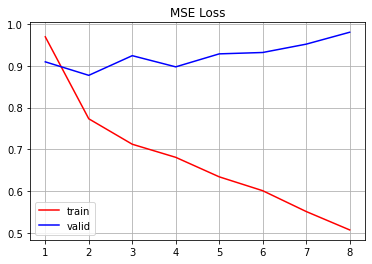


**************************************************

resnet Features, Fold: 4, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.05418 | Valid Loss: 0.93015 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.77746 | Valid Loss: 0.89807 | Time: 0.83 seconds
Epoch: 3 | Train Loss: 0.71550 | Valid Loss: 0.92702 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.67496 | Valid Loss: 0.92887 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.62134 | Valid Loss: 0.96103 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.58387 | Valid Loss: 0.93632 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.52277 | Valid Loss: 0.96499 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

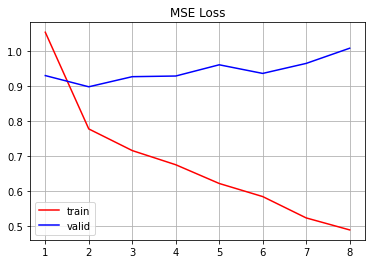


**************************************************

resnet Features, Fold: 4, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.13427 | Valid Loss: 0.90666 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.78084 | Valid Loss: 0.93566 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.70349 | Valid Loss: 0.91133 | Time: 0.64 seconds
Epoch: 4 | Train Loss: 0.64035 | Valid Loss: 0.95036 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.59328 | Valid Loss: 0.96683 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.55039 | Valid Loss: 0.96184 | Time: 0.60 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

T

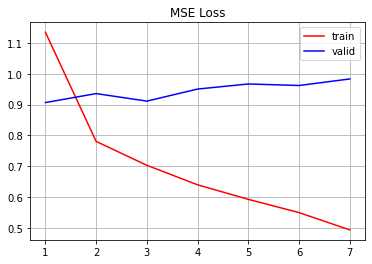


**************************************************

resnet Features, Fold: 4, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.35215 | Valid Loss: 0.96367 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.80480 | Valid Loss: 0.96720 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.72096 | Valid Loss: 0.96073 | Time: 0.80 seconds
Epoch: 4 | Train Loss: 0.66745 | Valid Loss: 0.95961 | Time: 0.70 seconds
Epoch: 5 | Train Loss: 0.59607 | Valid Loss: 0.98364 | Time: 0.63 seconds
Epoch: 6 | Train Loss: 0.54837 | Valid Loss: 0.98122 | Time: 0.63 seconds
Epoch: 7 | Train Loss: 0.49262 | Valid Loss: 1.02287 | Time: 0.62 seconds
Epoch: 8 | Train Loss: 0.44187 | Valid Loss: 1.02290 | Time: 0.62 seconds
Epoch: 9 | Train Loss: 0.39616 | Valid Loss: 1.07174 | Time: 0.64 seconds

Early Stopping at Epoch 9

******

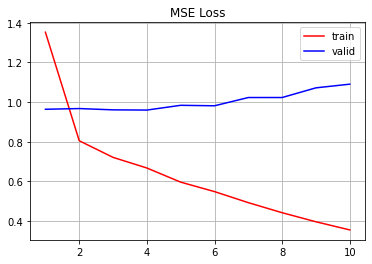


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

resnet Features, Fold: 5, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94672 | Valid Loss: 0.84665 | Time: 0.46 seconds
Epoch: 2 | Train Loss: 0.83306 | Valid Loss: 0.81808 | Time: 0.47 seconds
Epoch: 3 | Train Loss: 0.80639 | Valid Loss: 0.81889 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.78910 | Valid Loss: 0.81448 | Time: 0.47 seconds
Epoch: 5 | Train Loss: 0.78244 | Valid Loss: 0.82421 | Time: 0.45 seconds
Epoch: 6 | Train Loss: 0.76781 | Valid Loss: 0.80588 | Time: 0.58 seconds
Epoch: 7 | Train Loss: 0.76597 | Valid Loss: 0.81333 | Time: 0.95 seconds
Epoch: 8 | Train Loss: 0.75687 | Valid Loss: 0.81613 | Time: 0.50 seconds
Epoch: 9 | Trai

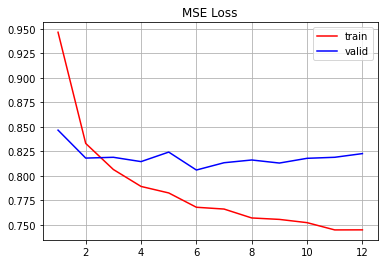


**************************************************

resnet Features, Fold: 5, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.89359 | Valid Loss: 0.78469 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.76348 | Valid Loss: 0.81375 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.73227 | Valid Loss: 0.81526 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.68793 | Valid Loss: 0.83716 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.66432 | Valid Loss: 0.83135 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.62258 | Valid Loss: 0.87266 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Tra

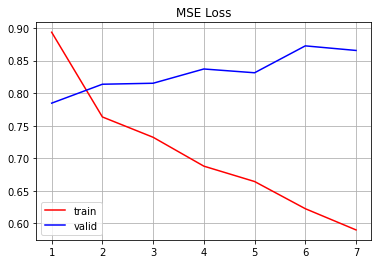


**************************************************

resnet Features, Fold: 5, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.94075 | Valid Loss: 0.80202 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.75928 | Valid Loss: 0.84365 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.71226 | Valid Loss: 0.81073 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.66955 | Valid Loss: 0.84286 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.63034 | Valid Loss: 0.86182 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.58159 | Valid Loss: 0.89682 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Tra

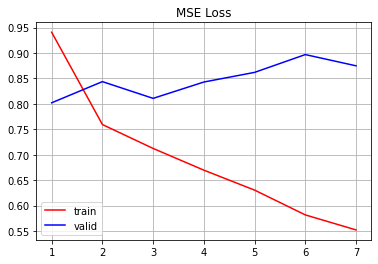


**************************************************

resnet Features, Fold: 5, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.05476 | Valid Loss: 0.84791 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.77212 | Valid Loss: 0.82040 | Time: 0.70 seconds
Epoch: 3 | Train Loss: 0.71158 | Valid Loss: 0.87229 | Time: 0.73 seconds
Epoch: 4 | Train Loss: 0.65989 | Valid Loss: 0.85060 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.61248 | Valid Loss: 0.88086 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.57076 | Valid Loss: 0.89955 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.52846 | Valid Loss: 0.91823 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

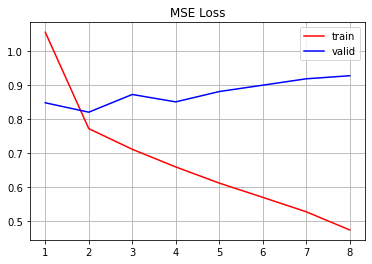


**************************************************

resnet Features, Fold: 5, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.14921 | Valid Loss: 0.87926 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.77394 | Valid Loss: 0.84322 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.69974 | Valid Loss: 0.86307 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.63881 | Valid Loss: 0.90119 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.58293 | Valid Loss: 0.91588 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.52831 | Valid Loss: 0.93712 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.48667 | Valid Loss: 0.97420 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epo

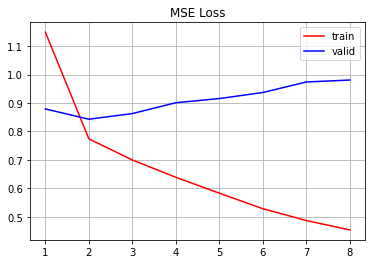


**************************************************

resnet Features, Fold: 5, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.36574 | Valid Loss: 0.91411 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.79228 | Valid Loss: 0.89574 | Time: 0.63 seconds
Epoch: 3 | Train Loss: 0.70973 | Valid Loss: 0.85537 | Time: 0.80 seconds
Epoch: 4 | Train Loss: 0.64279 | Valid Loss: 0.95827 | Time: 0.63 seconds
Epoch: 5 | Train Loss: 0.57853 | Valid Loss: 0.94365 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.52320 | Valid Loss: 0.98375 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.48509 | Valid Loss: 0.93995 | Time: 0.65 seconds
Epoch: 8 | Train Loss: 0.40779 | Valid Loss: 0.95668 | Time: 0.62 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Epoc

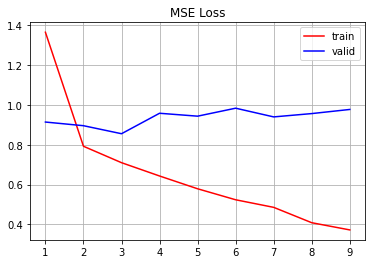

---
---
---
Loading Data ...

**************************************************

Splitting into Train and Validation Sets ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

vgg Features, Fold: 1, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98482 | Valid Loss: 0.91715 | Time: 0.58 seconds
Epoch: 2 | Train Loss: 0.80834 | Valid Loss: 0.89791 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.77299 | Valid Loss: 0.90846 | Time: 0.65 seconds
Epoch: 4 | Train Loss: 0.75589 | Valid Loss: 0.90416 | Time: 0.46 seconds
Epoch: 5 | Train Loss: 0.74373 | Valid Loss: 0.90022 | Time: 0.46 seconds
Epoch: 6 | Train Loss: 0.73208 | Valid Loss: 0.90764 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.72769 | Valid 

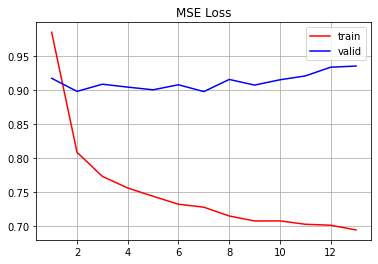


**************************************************

vgg Features, Fold: 1, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.92609 | Valid Loss: 0.86329 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.71701 | Valid Loss: 0.90203 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.62683 | Valid Loss: 0.94721 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.55480 | Valid Loss: 0.97448 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.46761 | Valid Loss: 1.03833 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.40711 | Valid Loss: 1.06551 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Traini

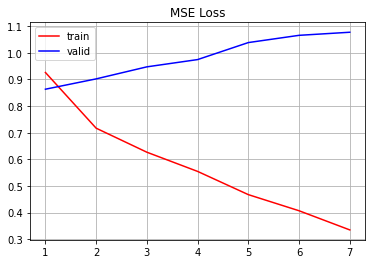


**************************************************

vgg Features, Fold: 1, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98312 | Valid Loss: 0.88885 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.69282 | Valid Loss: 0.89895 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.60641 | Valid Loss: 0.95673 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.51640 | Valid Loss: 0.99137 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.44831 | Valid Loss: 1.01919 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.35411 | Valid Loss: 1.12869 | Time: 0.61 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Traini

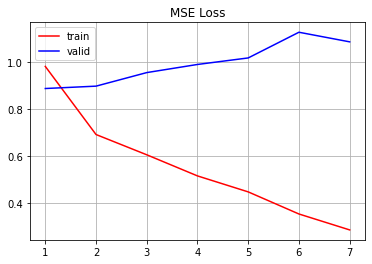


**************************************************

vgg Features, Fold: 1, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.07121 | Valid Loss: 0.95769 | Time: 0.83 seconds
Epoch: 2 | Train Loss: 0.69874 | Valid Loss: 0.94450 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.59690 | Valid Loss: 0.99575 | Time: 0.62 seconds
Epoch: 4 | Train Loss: 0.48866 | Valid Loss: 1.03675 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.40430 | Valid Loss: 1.07694 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.32794 | Valid Loss: 1.13422 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.25363 | Valid Loss: 1.10866 | Time: 0.61 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

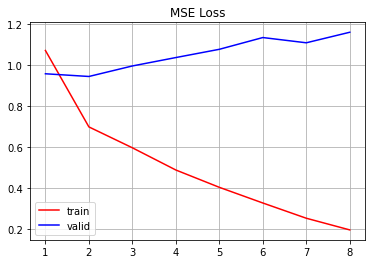


**************************************************

vgg Features, Fold: 1, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.14587 | Valid Loss: 0.93771 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.68425 | Valid Loss: 0.94964 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.55443 | Valid Loss: 1.00216 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.45948 | Valid Loss: 1.06341 | Time: 0.64 seconds
Epoch: 5 | Train Loss: 0.37363 | Valid Loss: 1.07142 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.27573 | Valid Loss: 1.07021 | Time: 0.64 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Trai

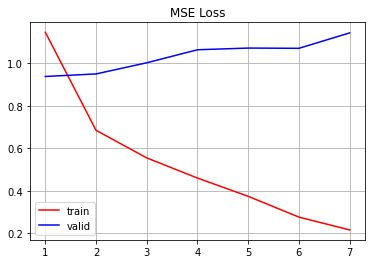


**************************************************

vgg Features, Fold: 1, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.41172 | Valid Loss: 1.01251 | Time: 0.65 seconds
Epoch: 2 | Train Loss: 0.70067 | Valid Loss: 1.00463 | Time: 0.72 seconds
Epoch: 3 | Train Loss: 0.55624 | Valid Loss: 1.06540 | Time: 0.70 seconds
Epoch: 4 | Train Loss: 0.44061 | Valid Loss: 1.10060 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.34948 | Valid Loss: 1.13718 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.27723 | Valid Loss: 1.13847 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.20734 | Valid Loss: 1.10503 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

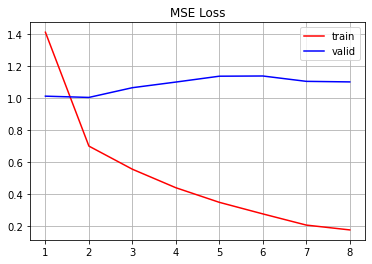


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

vgg Features, Fold: 2, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97057 | Valid Loss: 0.82891 | Time: 0.57 seconds
Epoch: 2 | Train Loss: 0.80338 | Valid Loss: 0.80497 | Time: 0.44 seconds
Epoch: 3 | Train Loss: 0.77023 | Valid Loss: 0.80138 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.75412 | Valid Loss: 0.81232 | Time: 0.45 seconds
Epoch: 5 | Train Loss: 0.73952 | Valid Loss: 0.80221 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.72849 | Valid Loss: 0.80909 | Time: 0.63 seconds
Epoch: 7 | Train Loss: 0.72400 | Valid Loss: 0.83760 | Time: 0.46 seconds
Epoch: 8 | Train Loss: 0.71890 | Valid Loss: 0.81684 | Time: 0.46 seconds

Early Stopping at

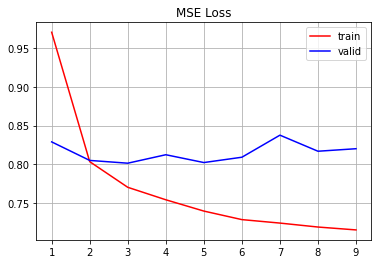


**************************************************

vgg Features, Fold: 2, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.92849 | Valid Loss: 0.77009 | Time: 0.65 seconds
Epoch: 2 | Train Loss: 0.72091 | Valid Loss: 0.79852 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.64686 | Valid Loss: 0.81712 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.56045 | Valid Loss: 0.86212 | Time: 0.80 seconds
Epoch: 5 | Train Loss: 0.49115 | Valid Loss: 0.87873 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.41533 | Valid Loss: 0.94184 | Time: 0.58 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Traini

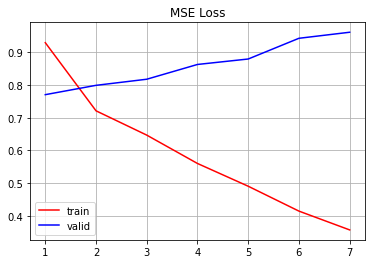


**************************************************

vgg Features, Fold: 2, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97981 | Valid Loss: 0.79343 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.70371 | Valid Loss: 0.79251 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.61397 | Valid Loss: 0.85796 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.53382 | Valid Loss: 0.90003 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.44645 | Valid Loss: 0.93908 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.35868 | Valid Loss: 0.97885 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.30122 | Valid Loss: 0.99503 | Time: 0.61 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs] 

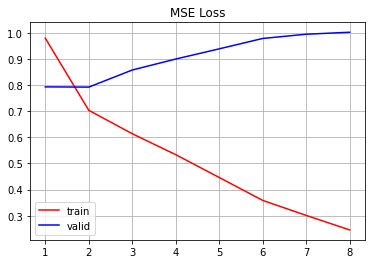


**************************************************

vgg Features, Fold: 2, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.07008 | Valid Loss: 0.82534 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.68785 | Valid Loss: 0.83455 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.58090 | Valid Loss: 0.86118 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.49502 | Valid Loss: 0.90225 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.39899 | Valid Loss: 1.00377 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.30605 | Valid Loss: 0.97981 | Time: 0.81 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Trai

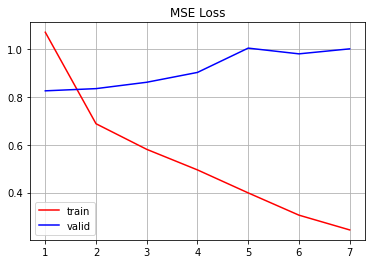


**************************************************

vgg Features, Fold: 2, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.18001 | Valid Loss: 0.85447 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.69163 | Valid Loss: 0.84443 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.57559 | Valid Loss: 0.88714 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.46008 | Valid Loss: 0.88292 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.37282 | Valid Loss: 0.95065 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.29264 | Valid Loss: 0.96003 | Time: 0.62 seconds
Epoch: 7 | Train Loss: 0.23159 | Valid Loss: 0.96870 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

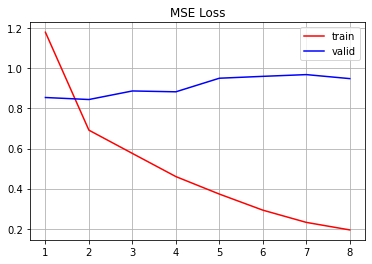


**************************************************

vgg Features, Fold: 2, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.37145 | Valid Loss: 0.90003 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.70534 | Valid Loss: 0.86603 | Time: 0.63 seconds
Epoch: 3 | Train Loss: 0.56496 | Valid Loss: 0.91492 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.45052 | Valid Loss: 0.95436 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.36811 | Valid Loss: 0.94674 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.27310 | Valid Loss: 0.96704 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.21169 | Valid Loss: 1.00413 | Time: 0.75 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

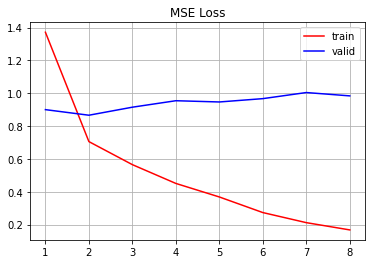


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

vgg Features, Fold: 3, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.97138 | Valid Loss: 0.92561 | Time: 0.48 seconds
Epoch: 2 | Train Loss: 0.80945 | Valid Loss: 0.91000 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.77737 | Valid Loss: 0.90881 | Time: 0.53 seconds
Epoch: 4 | Train Loss: 0.75477 | Valid Loss: 0.89282 | Time: 0.47 seconds
Epoch: 5 | Train Loss: 0.74388 | Valid Loss: 0.89566 | Time: 0.48 seconds
Epoch: 6 | Train Loss: 0.73113 | Valid Loss: 0.90526 | Time: 0.48 seconds
Epoch: 7 | Train Loss: 0.72005 | Valid Loss: 0.90382 | Time: 0.48 seconds
Epoch: 8 | Train Loss: 0.71936 | Valid Loss: 0.91716 | Time: 0.48 seconds
Epoch: 9 | Train L

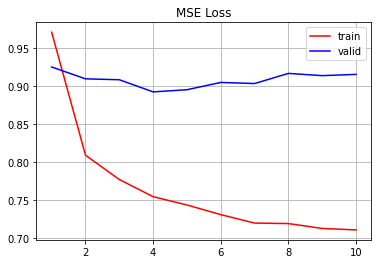


**************************************************

vgg Features, Fold: 3, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.92200 | Valid Loss: 0.88440 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.72201 | Valid Loss: 0.87457 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.64591 | Valid Loss: 0.90471 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.56776 | Valid Loss: 0.95198 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.49508 | Valid Loss: 0.98871 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.42514 | Valid Loss: 0.99846 | Time: 0.63 seconds
Epoch: 7 | Train Loss: 0.34883 | Valid Loss: 1.03505 | Time: 0.65 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs] 

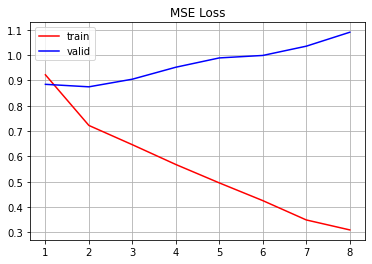


**************************************************

vgg Features, Fold: 3, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98807 | Valid Loss: 0.89159 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.69948 | Valid Loss: 0.92031 | Time: 0.64 seconds
Epoch: 3 | Train Loss: 0.60716 | Valid Loss: 0.91799 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.52059 | Valid Loss: 0.95668 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.42783 | Valid Loss: 0.98447 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.35575 | Valid Loss: 1.04845 | Time: 0.63 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Traini

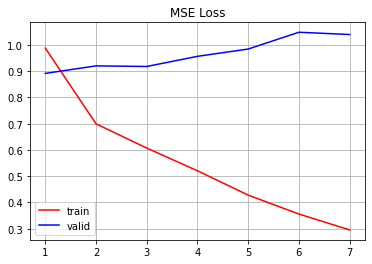


**************************************************

vgg Features, Fold: 3, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06913 | Valid Loss: 0.93481 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.69984 | Valid Loss: 0.96294 | Time: 0.61 seconds
Epoch: 3 | Train Loss: 0.58959 | Valid Loss: 0.99166 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.48819 | Valid Loss: 1.02664 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.39133 | Valid Loss: 1.01696 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.31046 | Valid Loss: 1.10371 | Time: 0.61 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Trai

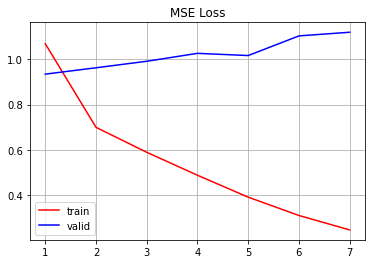


**************************************************

vgg Features, Fold: 3, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.16581 | Valid Loss: 0.93585 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.69471 | Valid Loss: 0.99241 | Time: 0.82 seconds
Epoch: 3 | Train Loss: 0.57999 | Valid Loss: 1.01695 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.45756 | Valid Loss: 0.99721 | Time: 0.64 seconds
Epoch: 5 | Train Loss: 0.36185 | Valid Loss: 1.06822 | Time: 0.62 seconds
Epoch: 6 | Train Loss: 0.28275 | Valid Loss: 1.06162 | Time: 0.62 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.08 minutes

**************************************************

Trai

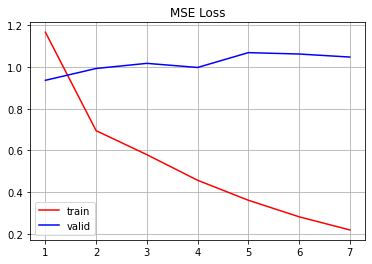


**************************************************

vgg Features, Fold: 3, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.35052 | Valid Loss: 1.00722 | Time: 0.63 seconds
Epoch: 2 | Train Loss: 0.71289 | Valid Loss: 0.99642 | Time: 0.65 seconds
Epoch: 3 | Train Loss: 0.56443 | Valid Loss: 1.06323 | Time: 0.61 seconds
Epoch: 4 | Train Loss: 0.45734 | Valid Loss: 1.03121 | Time: 0.64 seconds
Epoch: 5 | Train Loss: 0.35029 | Valid Loss: 1.08693 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.26590 | Valid Loss: 1.09361 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.20252 | Valid Loss: 1.05120 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

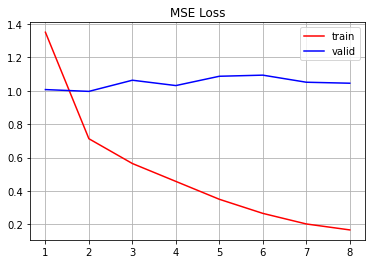


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

vgg Features, Fold: 4, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98020 | Valid Loss: 0.99241 | Time: 0.46 seconds
Epoch: 2 | Train Loss: 0.81288 | Valid Loss: 0.95090 | Time: 0.46 seconds
Epoch: 3 | Train Loss: 0.77313 | Valid Loss: 0.94688 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.75470 | Valid Loss: 0.95678 | Time: 0.76 seconds
Epoch: 5 | Train Loss: 0.74357 | Valid Loss: 0.94311 | Time: 0.71 seconds
Epoch: 6 | Train Loss: 0.72943 | Valid Loss: 0.94348 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.72372 | Valid Loss: 0.94756 | Time: 0.45 seconds
Epoch: 8 | Train Loss: 0.72060 | Valid Loss: 0.95067 | Time: 0.48 seconds
Epoch: 9 | Train L

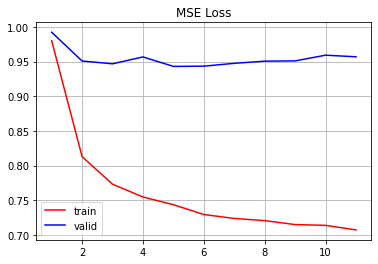


**************************************************

vgg Features, Fold: 4, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.91897 | Valid Loss: 0.91082 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.72127 | Valid Loss: 0.92052 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.65324 | Valid Loss: 0.90993 | Time: 0.84 seconds
Epoch: 4 | Train Loss: 0.56687 | Valid Loss: 0.99813 | Time: 0.69 seconds
Epoch: 5 | Train Loss: 0.49003 | Valid Loss: 1.03989 | Time: 0.59 seconds
Epoch: 6 | Train Loss: 0.41798 | Valid Loss: 1.06315 | Time: 0.59 seconds
Epoch: 7 | Train Loss: 0.35217 | Valid Loss: 1.10216 | Time: 0.59 seconds
Epoch: 8 | Train Loss: 0.28937 | Valid Loss: 1.09172 | Time: 0.59 seconds

Early Stopping at Epoch 8

**************************************************

Best Validation Loss at Epoch 3



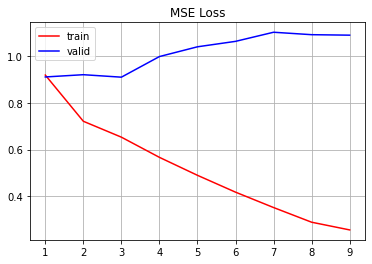


**************************************************

vgg Features, Fold: 4, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98989 | Valid Loss: 0.90037 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.70862 | Valid Loss: 0.92415 | Time: 0.80 seconds
Epoch: 3 | Train Loss: 0.61842 | Valid Loss: 0.99779 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.53408 | Valid Loss: 1.02183 | Time: 0.61 seconds
Epoch: 5 | Train Loss: 0.44774 | Valid Loss: 1.05467 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.35114 | Valid Loss: 1.08910 | Time: 0.59 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Traini

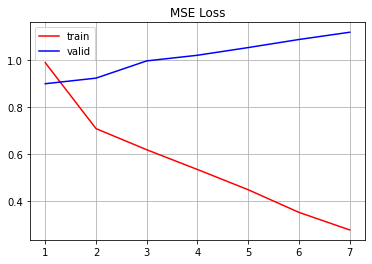


**************************************************

vgg Features, Fold: 4, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.08471 | Valid Loss: 0.94113 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.69841 | Valid Loss: 0.95037 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.59071 | Valid Loss: 0.97623 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.49580 | Valid Loss: 1.02900 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.41250 | Valid Loss: 1.05329 | Time: 0.65 seconds
Epoch: 6 | Train Loss: 0.32999 | Valid Loss: 1.10040 | Time: 0.62 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Trai

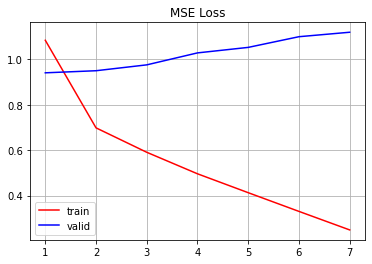


**************************************************

vgg Features, Fold: 4, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.17336 | Valid Loss: 0.95610 | Time: 0.60 seconds
Epoch: 2 | Train Loss: 0.69318 | Valid Loss: 0.94154 | Time: 0.62 seconds
Epoch: 3 | Train Loss: 0.57362 | Valid Loss: 0.99587 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.47435 | Valid Loss: 1.07593 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.37779 | Valid Loss: 1.06626 | Time: 0.86 seconds
Epoch: 6 | Train Loss: 0.28752 | Valid Loss: 1.09624 | Time: 0.61 seconds
Epoch: 7 | Train Loss: 0.22393 | Valid Loss: 1.07315 | Time: 0.61 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

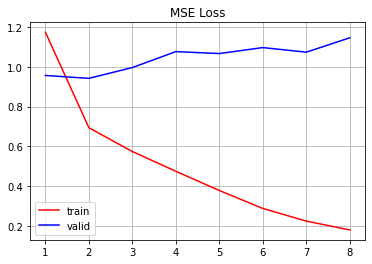


**************************************************

vgg Features, Fold: 4, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.37934 | Valid Loss: 0.97905 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.71861 | Valid Loss: 0.99739 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.56761 | Valid Loss: 1.00943 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.47424 | Valid Loss: 1.16035 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.37327 | Valid Loss: 1.13217 | Time: 0.63 seconds
Epoch: 6 | Train Loss: 0.28845 | Valid Loss: 1.11791 | Time: 0.60 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Trai

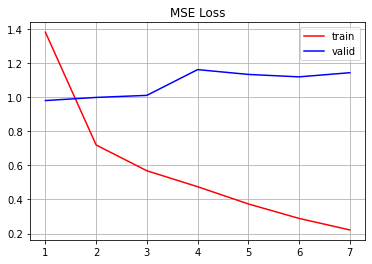


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

vgg Features, Fold: 5, HL: []

**************************************************

Building Model ...

2048 -> [] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.98913 | Valid Loss: 0.85247 | Time: 0.45 seconds
Epoch: 2 | Train Loss: 0.81806 | Valid Loss: 0.83835 | Time: 0.45 seconds
Epoch: 3 | Train Loss: 0.77959 | Valid Loss: 0.83242 | Time: 0.45 seconds
Epoch: 4 | Train Loss: 0.75635 | Valid Loss: 0.83435 | Time: 0.57 seconds
Epoch: 5 | Train Loss: 0.75047 | Valid Loss: 0.83202 | Time: 0.52 seconds
Epoch: 6 | Train Loss: 0.73316 | Valid Loss: 0.84627 | Time: 0.45 seconds
Epoch: 7 | Train Loss: 0.73245 | Valid Loss: 0.85131 | Time: 0.47 seconds
Epoch: 8 | Train Loss: 0.71927 | Valid Loss: 0.85347 | Time: 0.56 seconds
Epoch: 9 | Train L

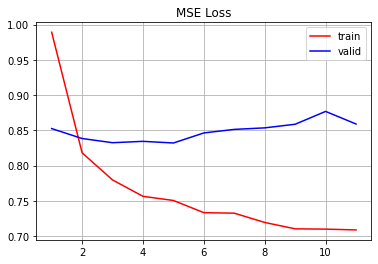


**************************************************

vgg Features, Fold: 5, HL: [32]

**************************************************

Building Model ...

2048 -> [32] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.91859 | Valid Loss: 0.79637 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.71841 | Valid Loss: 0.83207 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.65377 | Valid Loss: 0.85072 | Time: 0.58 seconds
Epoch: 4 | Train Loss: 0.58017 | Valid Loss: 0.91713 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.50351 | Valid Loss: 0.91702 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.42305 | Valid Loss: 1.03605 | Time: 0.90 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.08 minutes

**************************************************

Traini

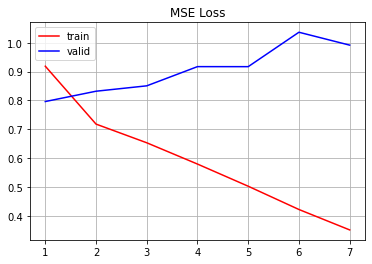


**************************************************

vgg Features, Fold: 5, HL: [64]

**************************************************

Building Model ...

2048 -> [64] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.99287 | Valid Loss: 0.82195 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.71111 | Valid Loss: 0.83602 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.61302 | Valid Loss: 0.89064 | Time: 0.59 seconds
Epoch: 4 | Train Loss: 0.52090 | Valid Loss: 0.93682 | Time: 0.58 seconds
Epoch: 5 | Train Loss: 0.43914 | Valid Loss: 0.97966 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.35615 | Valid Loss: 0.99753 | Time: 0.61 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Traini

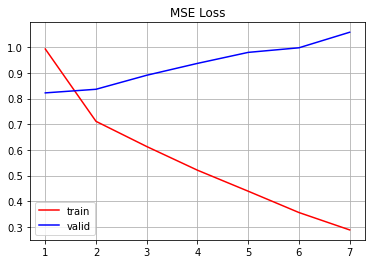


**************************************************

vgg Features, Fold: 5, HL: [128]

**************************************************

Building Model ...

2048 -> [128] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.06700 | Valid Loss: 0.86335 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.69789 | Valid Loss: 0.84564 | Time: 0.60 seconds
Epoch: 3 | Train Loss: 0.59777 | Valid Loss: 0.90165 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.50694 | Valid Loss: 0.93680 | Time: 0.62 seconds
Epoch: 5 | Train Loss: 0.40890 | Valid Loss: 0.97152 | Time: 0.62 seconds
Epoch: 6 | Train Loss: 0.32254 | Valid Loss: 1.00375 | Time: 0.64 seconds
Epoch: 7 | Train Loss: 0.24860 | Valid Loss: 1.02387 | Time: 0.60 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

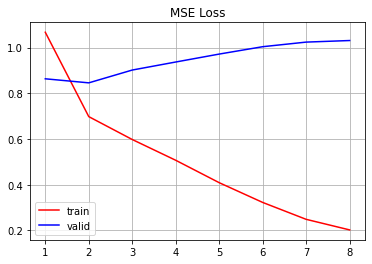


**************************************************

vgg Features, Fold: 5, HL: [256]

**************************************************

Building Model ...

2048 -> [256] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.19319 | Valid Loss: 0.88618 | Time: 0.61 seconds
Epoch: 2 | Train Loss: 0.69251 | Valid Loss: 0.89920 | Time: 0.59 seconds
Epoch: 3 | Train Loss: 0.58730 | Valid Loss: 0.90362 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.48559 | Valid Loss: 0.96198 | Time: 0.60 seconds
Epoch: 5 | Train Loss: 0.38382 | Valid Loss: 1.03565 | Time: 0.60 seconds
Epoch: 6 | Train Loss: 0.30628 | Valid Loss: 1.02553 | Time: 0.60 seconds

Early Stopping at Epoch 6

**************************************************

Best Validation Loss at Epoch 1

**************************************************

Time Taken [7 Epochs] : 0.07 minutes

**************************************************

Trai

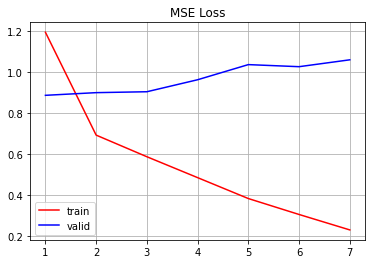


**************************************************

vgg Features, Fold: 5, HL: [512]

**************************************************

Building Model ...

2048 -> [512] -> 1

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.35663 | Valid Loss: 0.93405 | Time: 0.62 seconds
Epoch: 2 | Train Loss: 0.68668 | Valid Loss: 0.85993 | Time: 0.88 seconds
Epoch: 3 | Train Loss: 0.54707 | Valid Loss: 0.93579 | Time: 0.60 seconds
Epoch: 4 | Train Loss: 0.43871 | Valid Loss: 0.99929 | Time: 0.59 seconds
Epoch: 5 | Train Loss: 0.33413 | Valid Loss: 1.01160 | Time: 0.61 seconds
Epoch: 6 | Train Loss: 0.26667 | Valid Loss: 1.03763 | Time: 0.60 seconds
Epoch: 7 | Train Loss: 0.21040 | Valid Loss: 1.06373 | Time: 0.59 seconds

Early Stopping at Epoch 7

**************************************************

Best Validation Loss at Epoch 2

**************************************************

Time Taken [8 Epochs

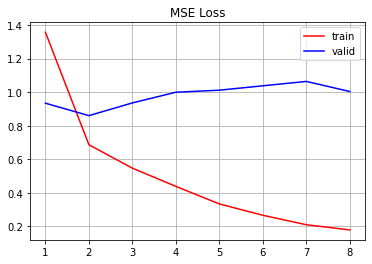


**************************************************

Total Time to search for optimal HL : 10.68 minutes

**************************************************



In [10]:
params = search()

In [11]:
for i in range(len(params)):
    print(params[i])

with open("params.pkl", "wb") as fp:
    pickle.dump(params, fp)

{'Model': 'mobilenet', 'Fold': 1, 'HL': [], 'RMSE': 0.9383473816281163}
{'Model': 'mobilenet', 'Fold': 1, 'HL': [32], 'RMSE': 0.9444157570279661}
{'Model': 'mobilenet', 'Fold': 1, 'HL': [64], 'RMSE': 0.9405454822655547}
{'Model': 'mobilenet', 'Fold': 1, 'HL': [128], 'RMSE': 0.9603341205029742}
{'Model': 'mobilenet', 'Fold': 1, 'HL': [256], 'RMSE': 0.9685164326787493}
{'Model': 'mobilenet', 'Fold': 1, 'HL': [512], 'RMSE': 0.9825037709125783}
{'Model': 'mobilenet', 'Fold': 2, 'HL': [], 'RMSE': 0.8860570962001448}
{'Model': 'mobilenet', 'Fold': 2, 'HL': [32], 'RMSE': 0.8867992241970911}
{'Model': 'mobilenet', 'Fold': 2, 'HL': [64], 'RMSE': 0.8883794239261964}
{'Model': 'mobilenet', 'Fold': 2, 'HL': [128], 'RMSE': 0.909417976894117}
{'Model': 'mobilenet', 'Fold': 2, 'HL': [256], 'RMSE': 0.9049409360378585}
{'Model': 'mobilenet', 'Fold': 2, 'HL': [512], 'RMSE': 0.9460576995791928}
{'Model': 'mobilenet', 'Fold': 3, 'HL': [], 'RMSE': 0.9411404722258362}
{'Model': 'mobilenet', 'Fold': 3, 'HL':

In [12]:
breaker()
print("Notebook Run Time : {:.2f} minutes".format((time()-notebook_start_time)/60))
breaker()


**************************************************

Notebook Run Time : 10.81 minutes

**************************************************

